In [12]:
# importing packages and modules
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize
from utils import *
from plotting_utils import *
from analysis_utils import *
import dglm_hmm1
from scipy.stats import multivariate_normal, norm
# import jax

sns.set_context("talk")

In [13]:
# setting hyperparameters
S = 10 # sessions
T = 500 # trials per session
N = T * S # total data points
C = 2 # classes
K = 2 # states
D = 2 # features (sensory & bias)

True Transition Matrix P
[[0.97 0.03]
 [0.05 0.95]]


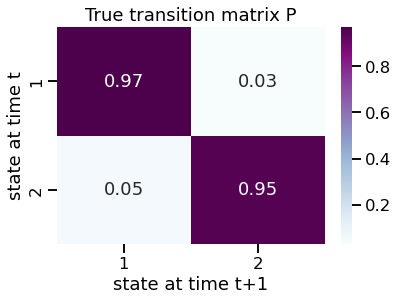

In [3]:
# True Transition Matrix
trueP = np.zeros((2,2))
trueP[0,0]=0.97
trueP[0,1]=0.03
trueP[1,0]=.05
trueP[1,1]=.95
print("True Transition Matrix P")
s = sns.heatmap(trueP,annot=True,cmap='BuPu', fmt='g')
s.set(xlabel='state at time t+1', ylabel='state at time t', title='True transition matrix P', xticklabels=[1,2], yticklabels=[1,2])
fig = s.get_figure()
#fig.savefig('../figures/trueP_2-states' , dpi=400, bbox_inches="tight")
print(trueP)

Session indicies
[0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
(5000, 2, 2, 2)


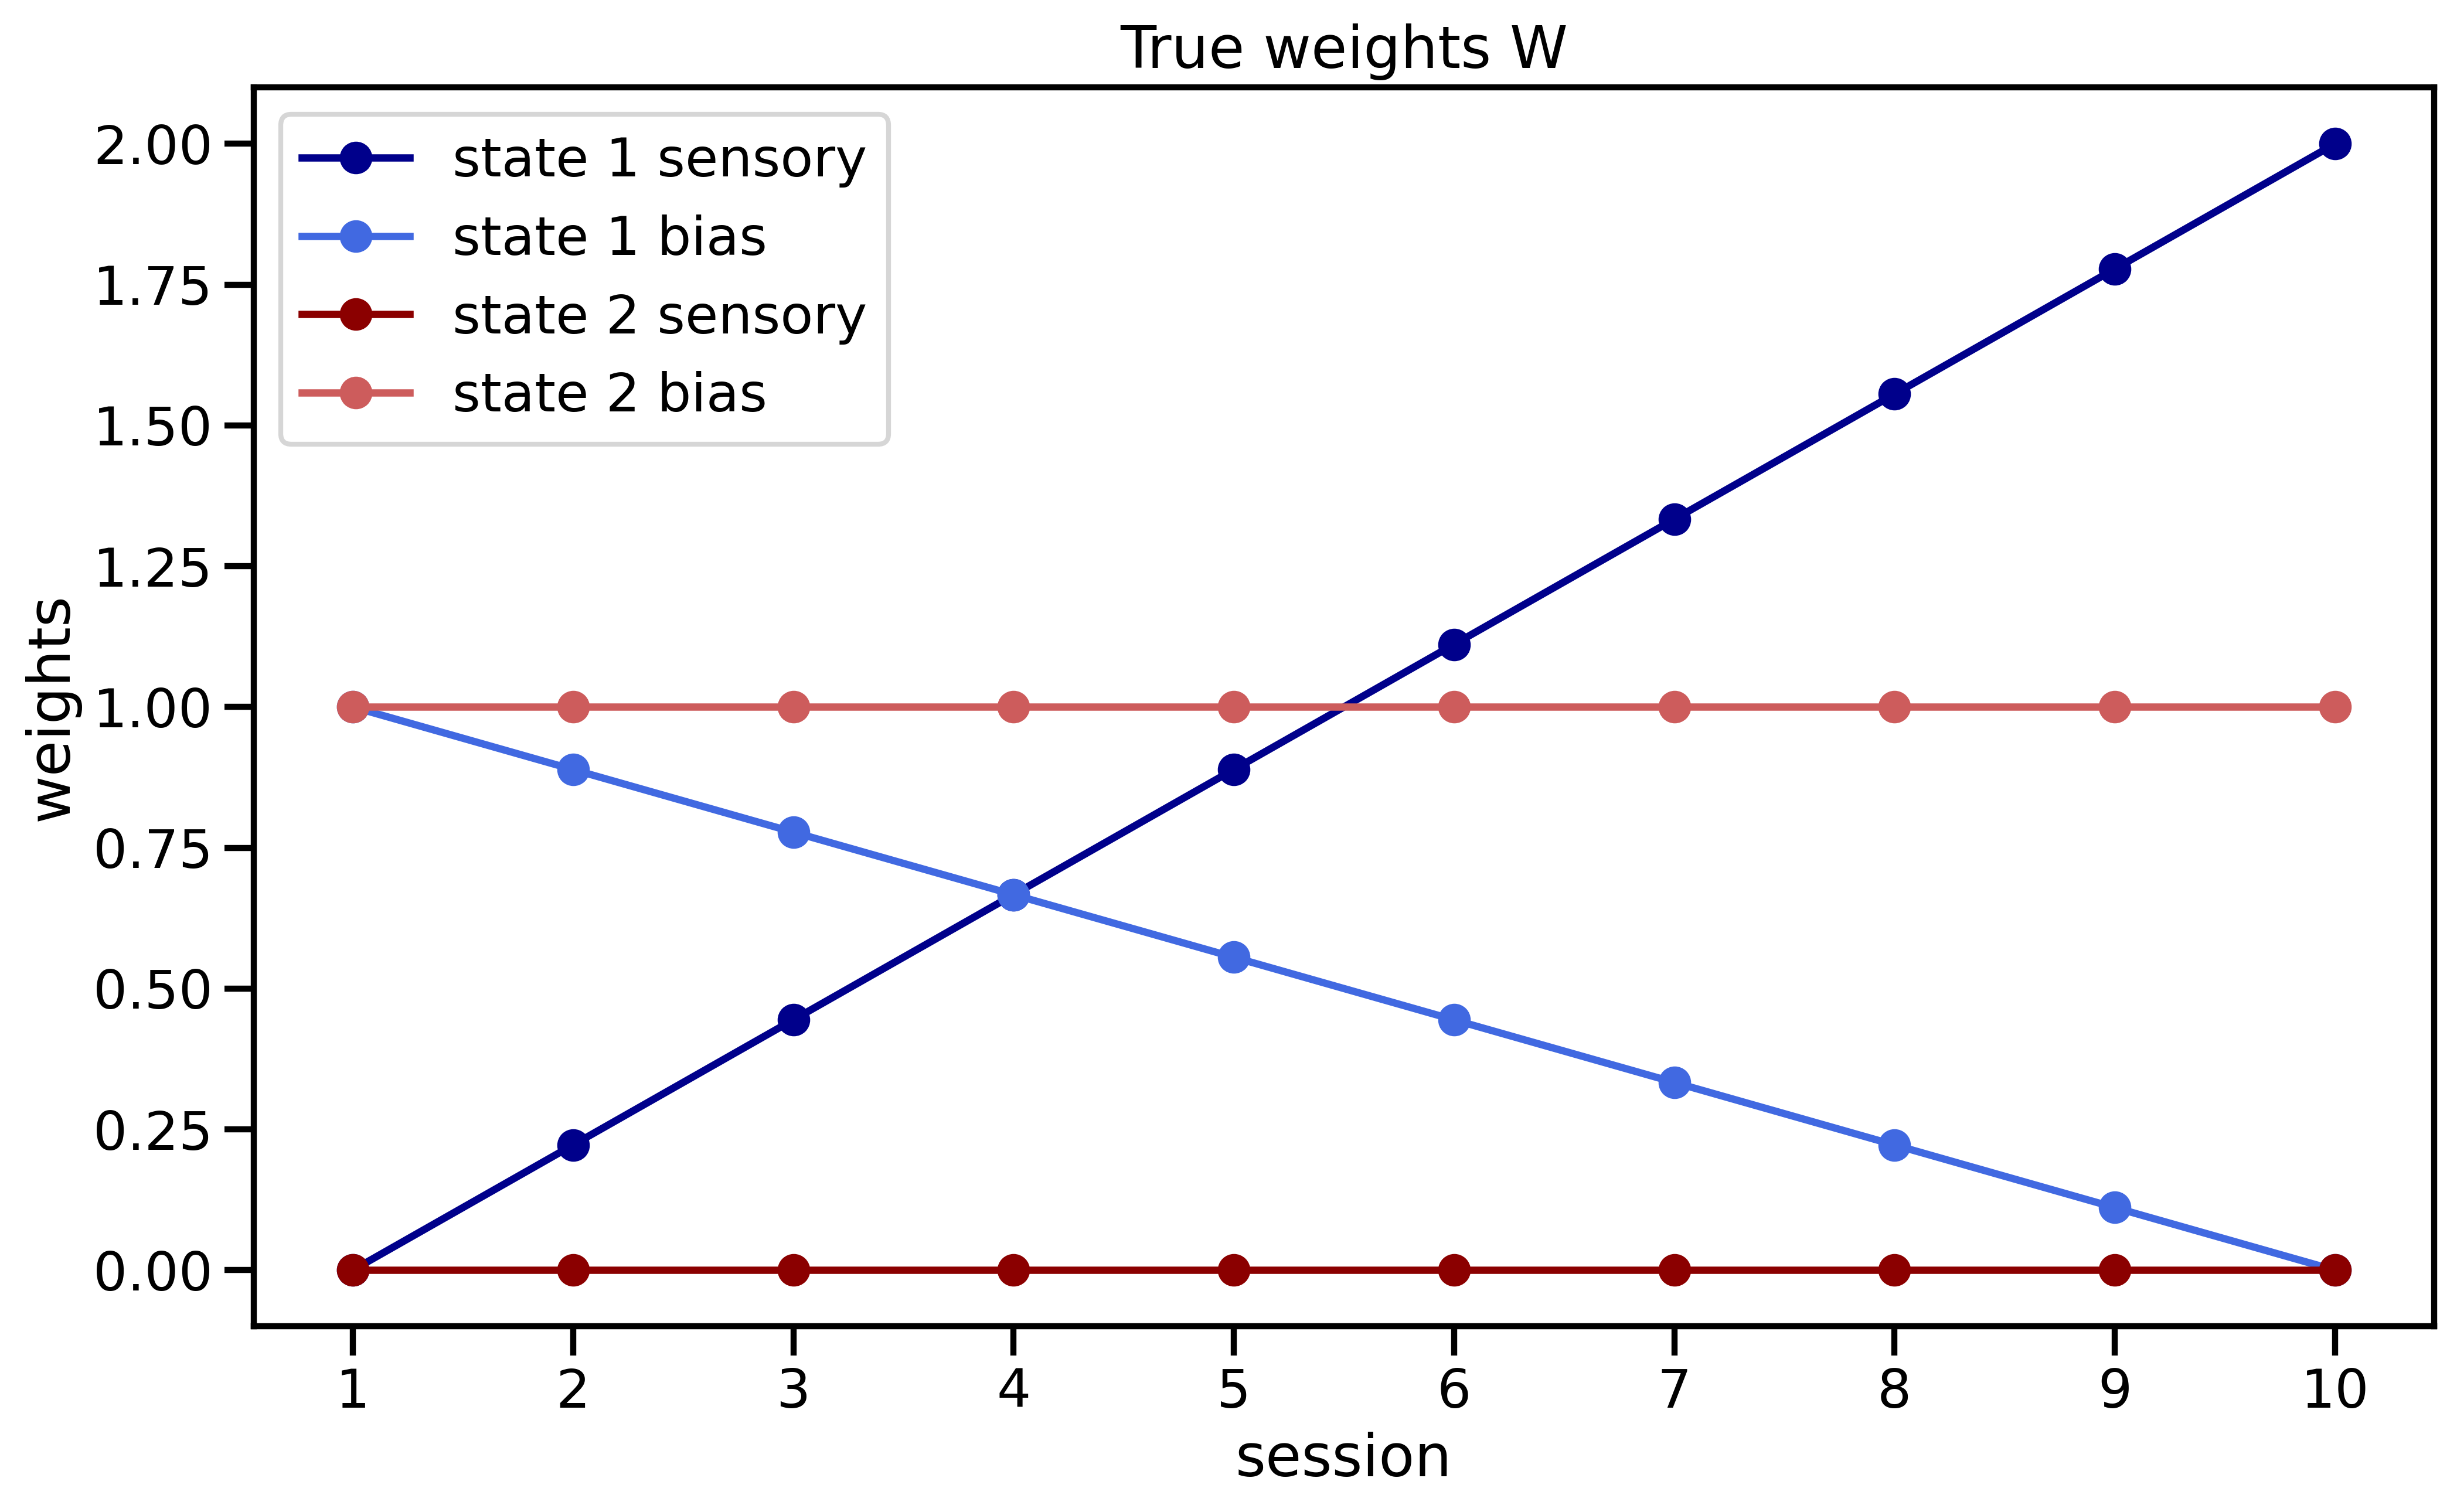

In [4]:
# True Weights and Session Start Indices
ourW = np.zeros((S,K,D))
ourW[:,0,1] = np.linspace(0,2,S) # state 1 sensory (increasing)
ourW[:,0,0] = np.linspace(1,0,S) # state 1 bias (decreasing)
ourW[:,1,1] = 0 # state 2 sensory (flat 0)
ourW[:,1,0] = 1 # state 2 bias (flat 1)
trueW = np.zeros((N,K,D,C))
# change weight format to have session*trials points
sessInd = []
for sess in range(0,S):
    sessInd.append(sess*T)
    for t in range(0,T):
        trueW[sess*T+t,:,:,0] = ourW[sess,:,:]
sessInd.append(N)
print("Session indicies")
print(sessInd)

testSessInd = []
for sess in range(0,S+1):
    testSessInd.append(sess*1000)

print(trueW.shape)
fig, axes = plt.subplots(1, figsize = (12,7), dpi=400)
plotting_weights(w=trueW, sessInd=sessInd, axes=axes, trueW=None, title='True weights W', save_fig=False)

In [5]:
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)

#_, _, _= dGLM_HMM.simulate_data(trueW, trueP, sessInd, save=True, title=f'../data/N={N}_{K}_state_constant-drift_train')
#_, _, _= dGLM_HMM.simulate_data(trueW, trueP, sessInd, save=True, title=f'../data/{K}_state_constant-drift_test') # test has size N=1000*10
trainX = np.load(f'../data/N={N}_{K}_state_constant-drift_trainX.npy')
trainY = np.load(f'../data/N={N}_{K}_state_constant-drift_trainY.npy')

In [10]:
# ourSigma = np.zeros((2,2)) # k x d
# ourSigma[0,0] = 0.11
# ourSigma[0,1] = 0.22
# ourSigma[1,0] = 0.01
# ourSigma[1,1] = 0.01
oneSessInd = [0,N]

# initP0, initW0 = dGLM_HMM.generate_param(sessInd=oneSessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-2,2)]) 
# initP,  initW, _ = dGLM_HMM.fit(trainX, trainY,  initP0, initW0, sigma=reshapeSigma(1, K, D), sessInd=oneSessInd, pi0=None, maxIter=300, tol=1e-4) # sigma does not matter here
allW = np.load('../data//W_N=5000_2_state_constant-drift.npy')
allP = np.load('../data//P_N=5000_2_state_constant-drift.npy')
checkP, checkW, checkLl = dGLM_HMM.fit(trainX, trainY,  initP=allP[0,10], initW=allW[0,10], sigma=reshapeSigma(0.2, K, D), sessInd=sessInd, pi0=None, maxIter=300, tol=1e-4) # fit the model

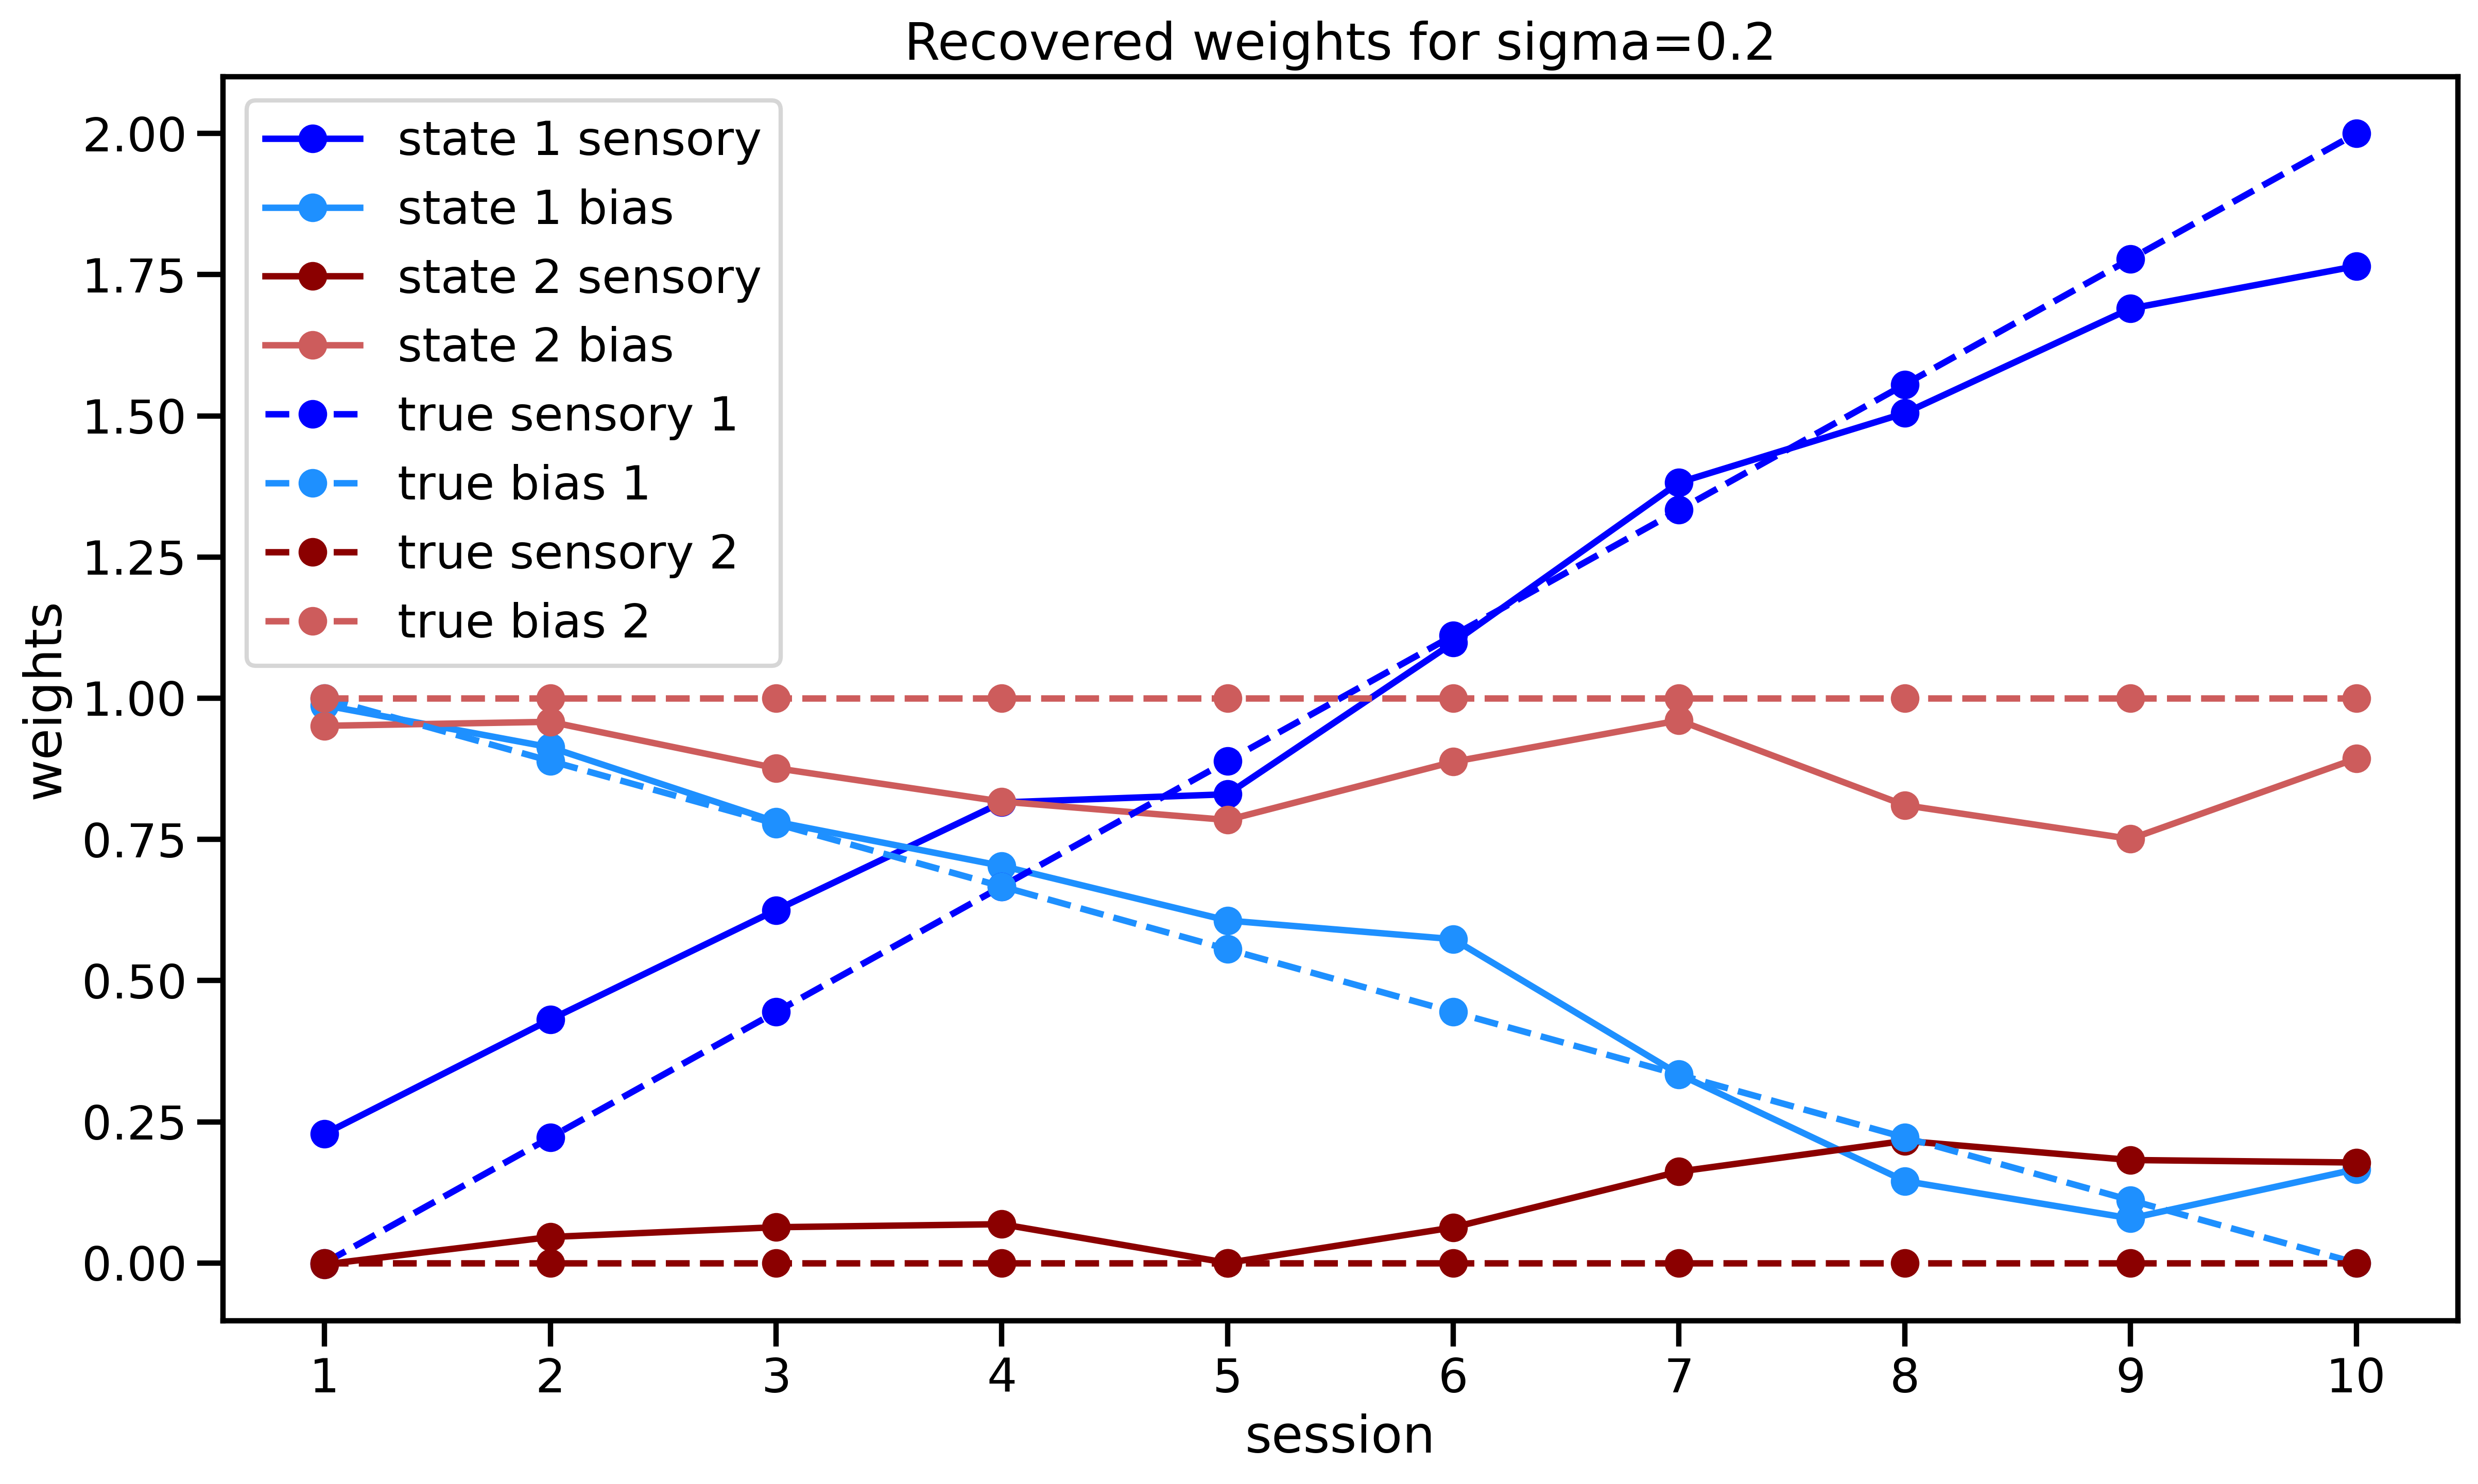

In [52]:
fig, axes = plt.subplots(1, figsize = (14,8), dpi=400)
plotting_weights(permute_states(checkW,sessInd), sessInd, axes=axes,  trueW=trueW, title=f'Recovered weights for sigma=0.2', save_fig=True)

In [6]:
p =np.zeros((2,2))
p[0,0] = checkP[1,1]
p[0,1] = checkP[1,0]
p[1,1] = checkP[0,0]
p[1,0] = checkP[0,1]
s = sns.heatmap(p,annot=True,cmap='BuPu', fmt='.2g')
s.set(xlabel='state at time t+1', ylabel='state at time t', title='Recovered transition matrix', xticklabels=[1,2], yticklabels=[1,2])
fig = s.get_figure()
fig.savefig('../figures/RecoveredP_2-states' , dpi=400, bbox_inches="tight")
print(p)

NameError: name 'checkP' is not defined

In [6]:
testX = np.load(f'../data/{K}_state_constant-drift_testX.npy')
testY = np.load(f'../data/{K}_state_constant-drift_testY.npy')
# testPhi = dGLM_HMM.observation_probability(testX, reshapeWeights(checkW[0], sessInd, testSessInd))
# _, _, testLl = dGLM_HMM.forward_pass(testY,checkP[0],testPhi)
# print("test LL per trial=", testLl/N/2)

#plotting_weights(checkW, sessInd, trueW, 'recovered weights sigma=0.1')

In [29]:
sigmaList = [0] + [2**x for x in list(np.arange(-10,-4,1,dtype=float))] + [2**x for x in list(np.arange(-4,1,0.5,dtype=float))] + [2**x for x in list(np.arange(1,8,2,dtype=float))]
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,3,D,C) # fitting with one state the two state model
inits=1
maxiter=300
modelType='constant-drift'
simX = np.load(f'../data/N={N}_{K}_state_{modelType}_trainX.npy')
simY = np.load(f'../data/N={N}_{K}_state_{modelType}_trainY.npy')

allLl = np.zeros((inits, len(sigmaList), maxiter))
allP = np.zeros((inits, len(sigmaList), 3,3))
allW = np.zeros((inits, len(sigmaList),N,3,D,C))

oneSessInd = [0,N] # treating whole dataset as one session for normal GLM-HMM fitting
 
for init in range(0,inits):
    for indSigma in range(0,len(sigmaList)): 
        print(indSigma)
        if (indSigma == 0): 
            if(sigmaList[0] == 0):
                initP0, initW0 = dGLM_HMM.generate_param(sessInd=oneSessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-2,2)]) 
                allP[init, indSigma],  allW[init, indSigma], allLl[init, indSigma] = dGLM_HMM.fit(simX, simY,  initP0, initW0, sigma=reshapeSigma(1, 3, D), sessInd=oneSessInd, pi0=None, maxIter=300, tol=1e-4) # sigma does not matter here
            else:
                initP, initW = dGLM_HMM.generate_param(sessInd=sessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-2,2)]) # initialize the model parameters
        else:
            initP = allP[init, indSigma-1] 
            initW = allW[init, indSigma-1] 
            
        if(sigmaList[indSigma] != 0):
            # fit on whole dataset
            allP[init, indSigma],  allW[init, indSigma], allLl[init, indSigma] = dGLM_HMM.fit(simX, simY,  initP, initW, sigma=reshapeSigma(sigmaList[indSigma], 3, D), sessInd=sessInd, pi0=None, maxIter=maxiter, tol=1e-3) # fit the model
                
    np.save(f'../data/Ll_N={N}_3-fit_{K}_state_{modelType}', allLl)
    np.save(f'../data/P_N={N}_3-fit_{K}_state_{modelType}', allP)
    np.save(f'../data/W_N={N}_3-fit_{K}_state_{modelType}', allW)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


(5000, 3, 2, 2)


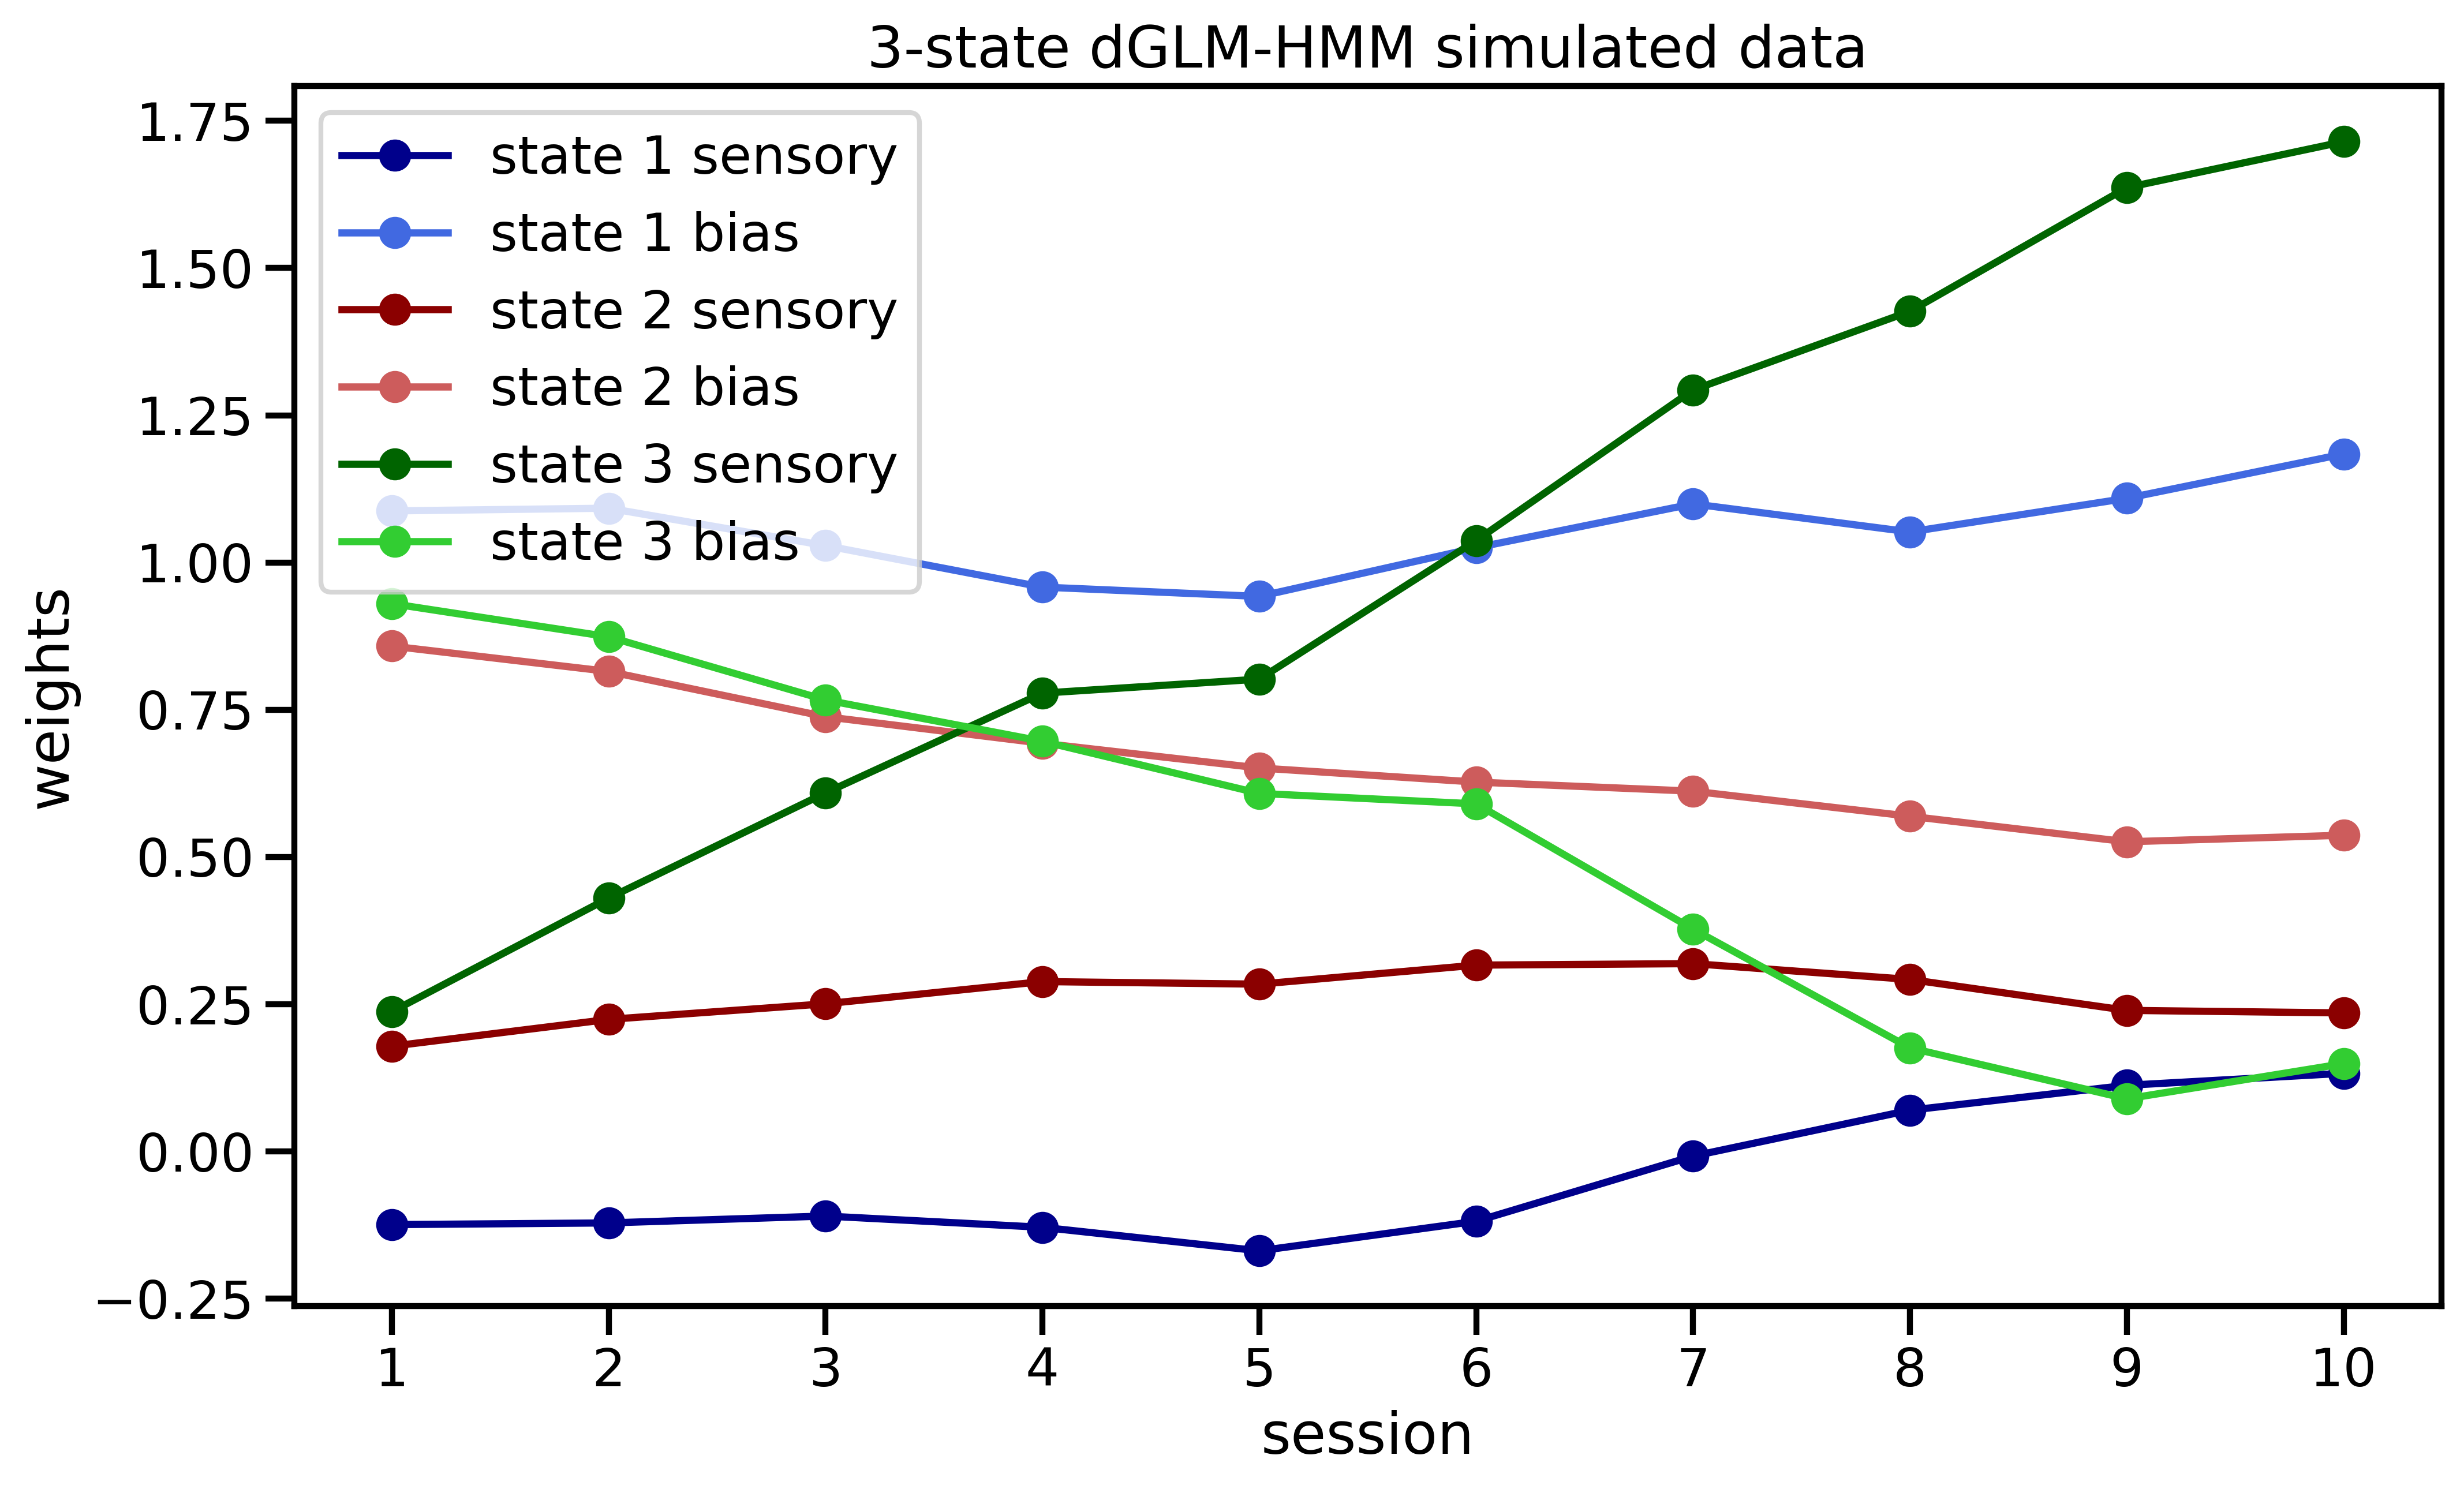

In [8]:
W = np.load(f'../data/W_N=5000_3-fit_2_state_constant-drift.npy')
print(W[0,10].shape)
fig, axes = plt.subplots(1, figsize = (12,7), dpi=400)
plotting_weights(w=W[0,10], sessInd=sessInd, axes=axes, trueW=None, title='3-state dGLM-HMM simulated data', save_fig=True)

[0 0 0 ... 1 1 0]


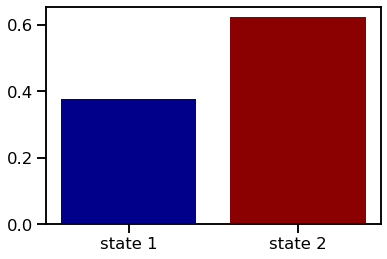

In [21]:
w = np.load(f'../data/W_N=5000_2_state_constant-drift.npy')
p = np.load(f'../data/P_N=5000_2_state_constant-drift.npy')
dGLM_HMM3 = dglm_hmm1.dGLM_HMM1(N,K,D,C)
z = dGLM_HMM3.assign_states_in_time(trainX, trainY, w[0,10], p[0,10], sessInd=sessInd)
print(z)

fig, axes = plt.subplots(1)
plotting_state_occupancy(z, axes)

    

[0 0 0 ... 2 2 2]


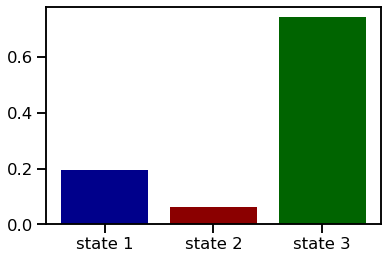

In [22]:
w = np.load(f'../data/W_N=5000_3-fit_2_state_constant-drift.npy')
p = np.load(f'../data/P_N=5000_3-fit_2_state_constant-drift.npy')
dGLM_HMM3 = dglm_hmm1.dGLM_HMM1(N,3,D,C)
z = dGLM_HMM3.assign_states_in_time(trainX, trainY, w[0,10], p[0,10], sessInd=sessInd)
print(z)

fig, axes = plt.subplots(1)
def plotting_state_occupancy(z, axes):
    K = len(np.unique(z)) # number of states
    percent_time = np.zeros((K,))
    labels = ['state %s' %(i+1) for i in range(K)]
    for i in range(0,K):
        percent_time[i] = len(np.argwhere(z==i))/z.shape[0]

    axes.bar(labels, percent_time, color=colors_dark)

plotting_state_occupancy(z, axes)

(1, 21)
(1, 21)
(1, 21)


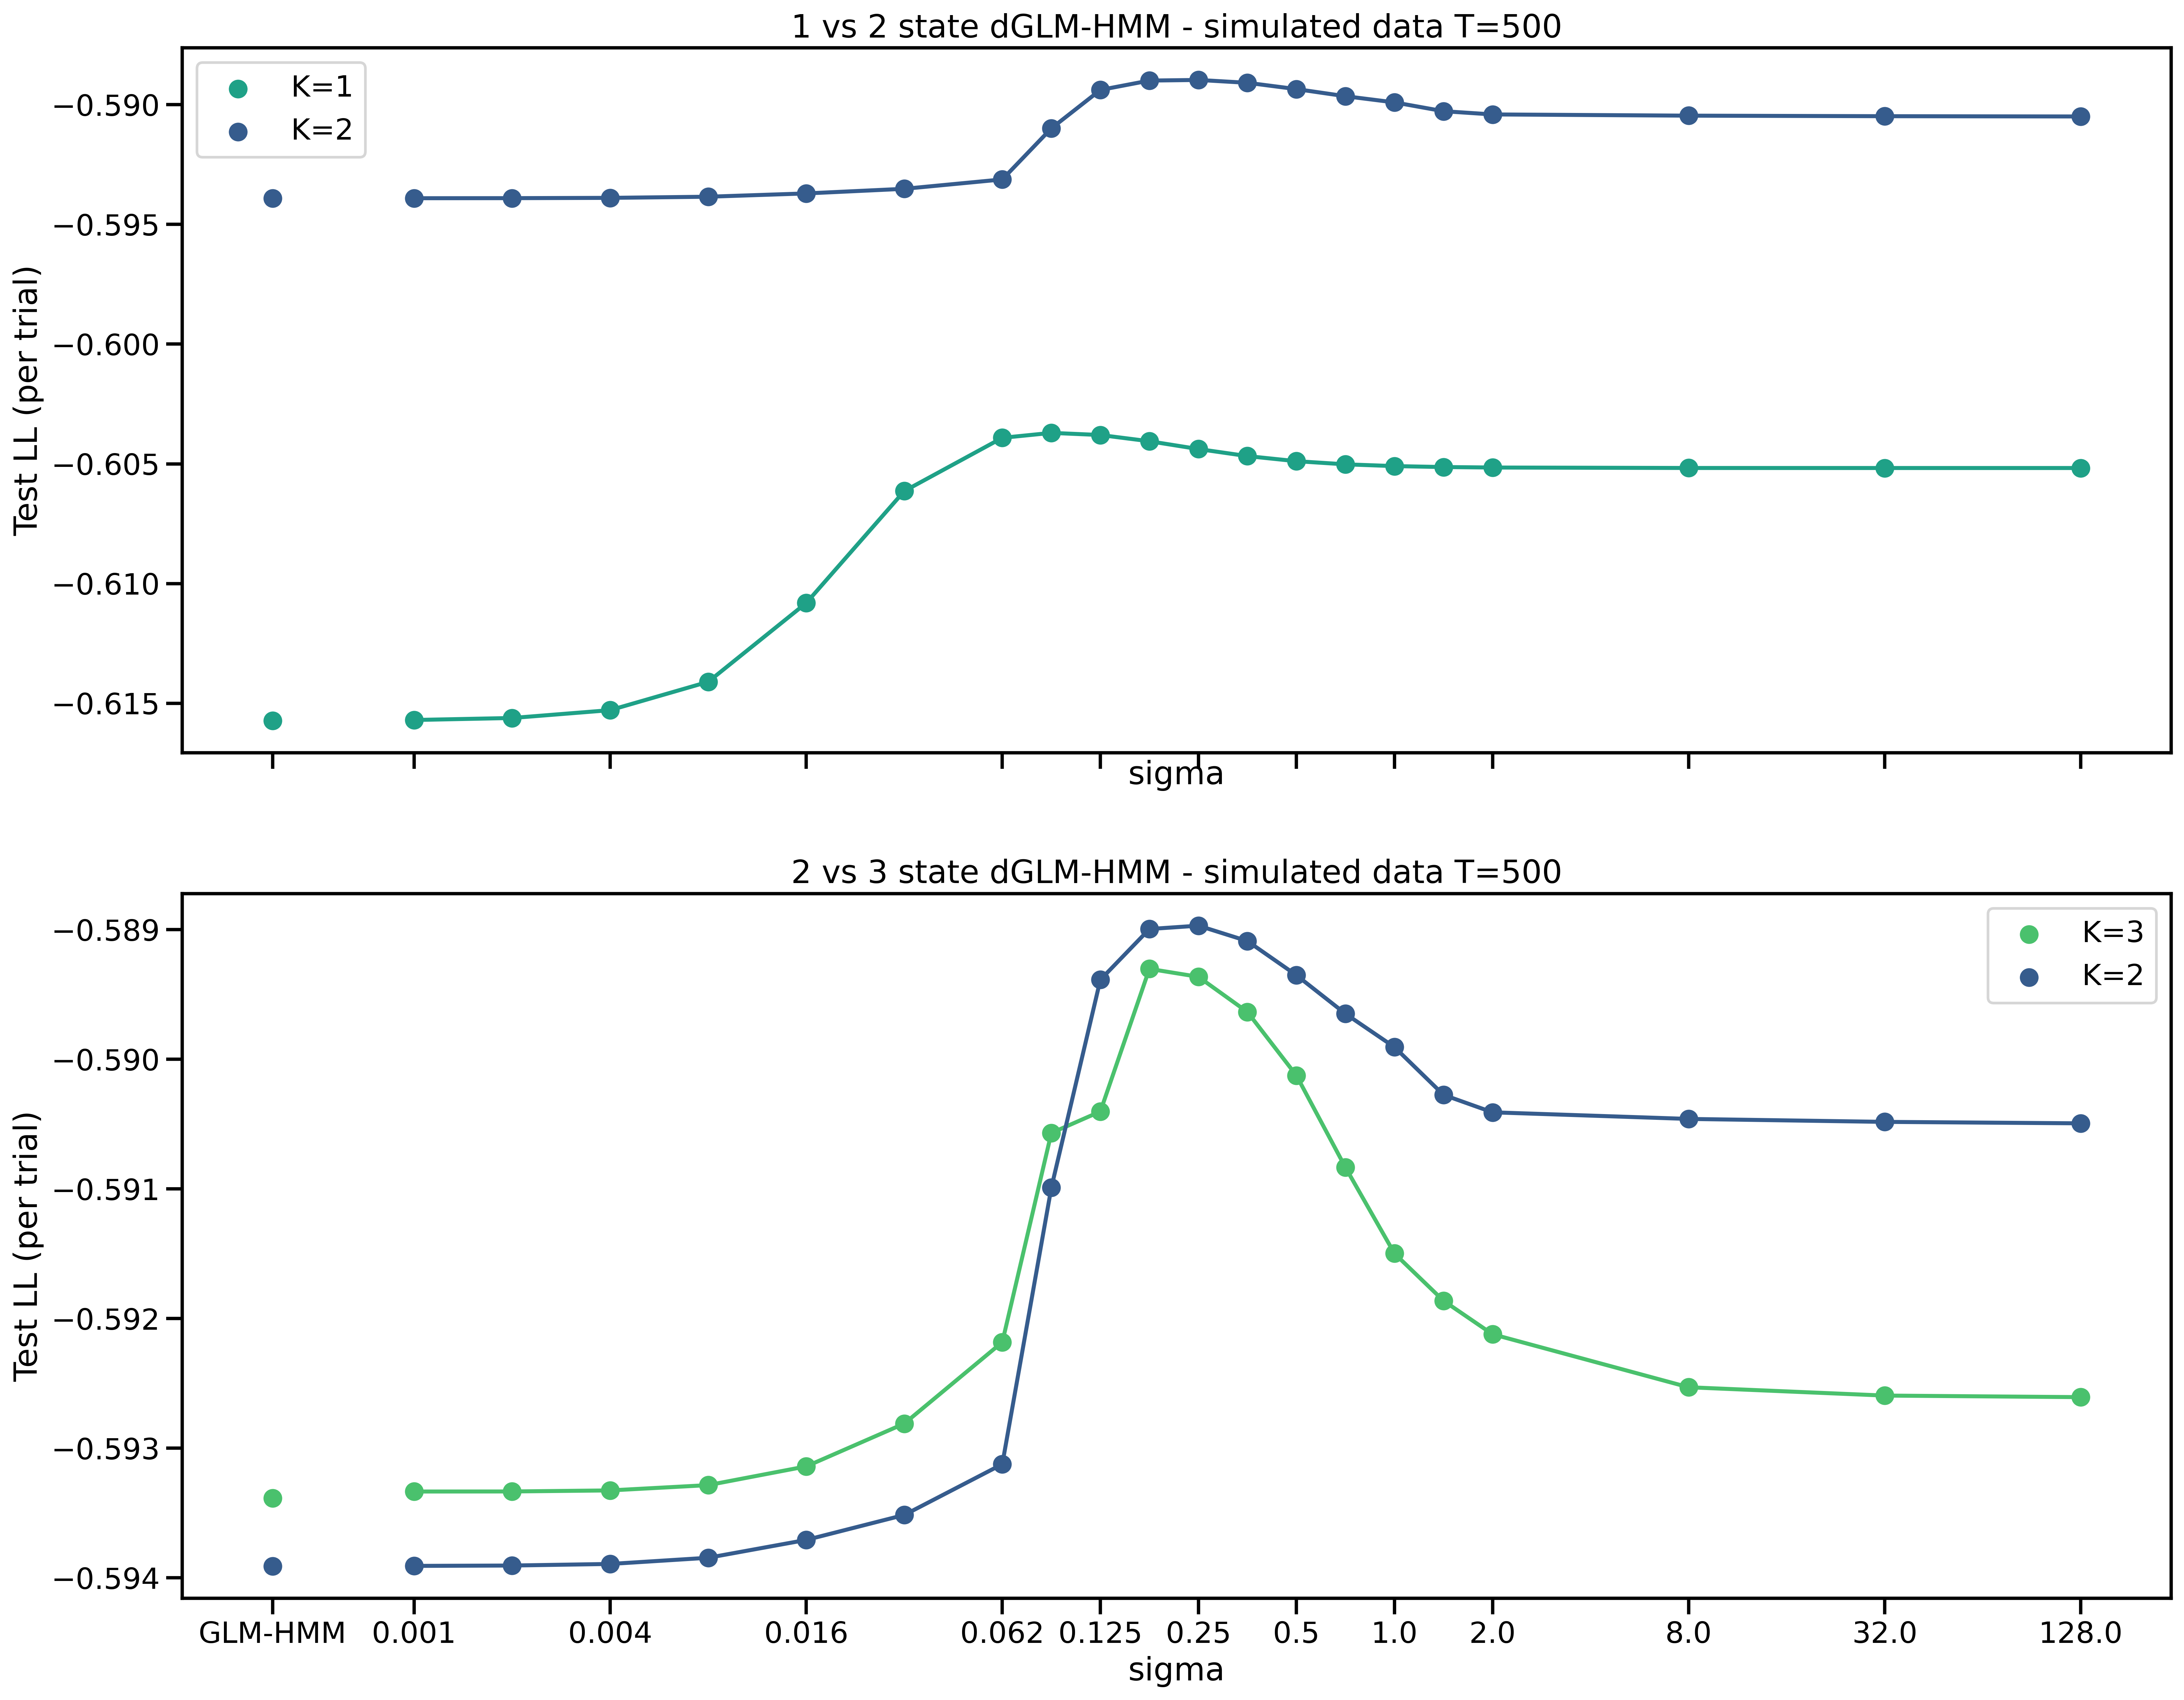

In [8]:
modelType='constant-drift'
sigmaList = [0] + [2**x for x in list(np.arange(-10,-4,1,dtype=float))] + [2**x for x in list(np.arange(-4,1,0.5,dtype=float))] + [2**x for x in list(np.arange(1,8,2,dtype=float))]
testLl1 = np.load(f'../data/testLl_N={N}_1-fit_{K}_state_{modelType}.npy')
print(testLl1.shape)
testLl2 = np.load(f'../data/testLl_N={N}_{K}_state_{modelType}.npy')
print(testLl2[0,:].reshape((1,21)).shape)
testLl3 = np.load(f'../data/testLl_N={N}_3-fit_{K}_state_{modelType}.npy')
print(testLl3.shape)
fig, axes = plt.subplots(2, 1, figsize = (20,16), dpi=400, sharex=True)
sigma_testLl_plot(K=1, sigmaList=sigmaList, testLl=testLl1, axes=axes[0], title='2 state dGLM-HMM - simulated data T=500', labels=['K=1'], color=3, save_fig=False)
sigma_testLl_plot(K=2, sigmaList=sigmaList, testLl=testLl2[0,:].reshape((1,21)), axes=axes[0], title='1 vs 2 state dGLM-HMM - simulated data T=500', labels=['K=2'], color=1, save_fig=False)
sigma_testLl_plot(K=3, sigmaList=sigmaList, testLl=testLl3, axes=axes[1], title='2 state dGLM-HMM - simulated data T=500', labels=['K=3'], color=4, save_fig=False)
sigma_testLl_plot(K=2, sigmaList=sigmaList, testLl=testLl2[0,:].reshape((1,21)), axes=axes[1], title='2 vs 3 state dGLM-HMM - simulated data T=500', labels=['K=2'], color=1, save_fig=True)


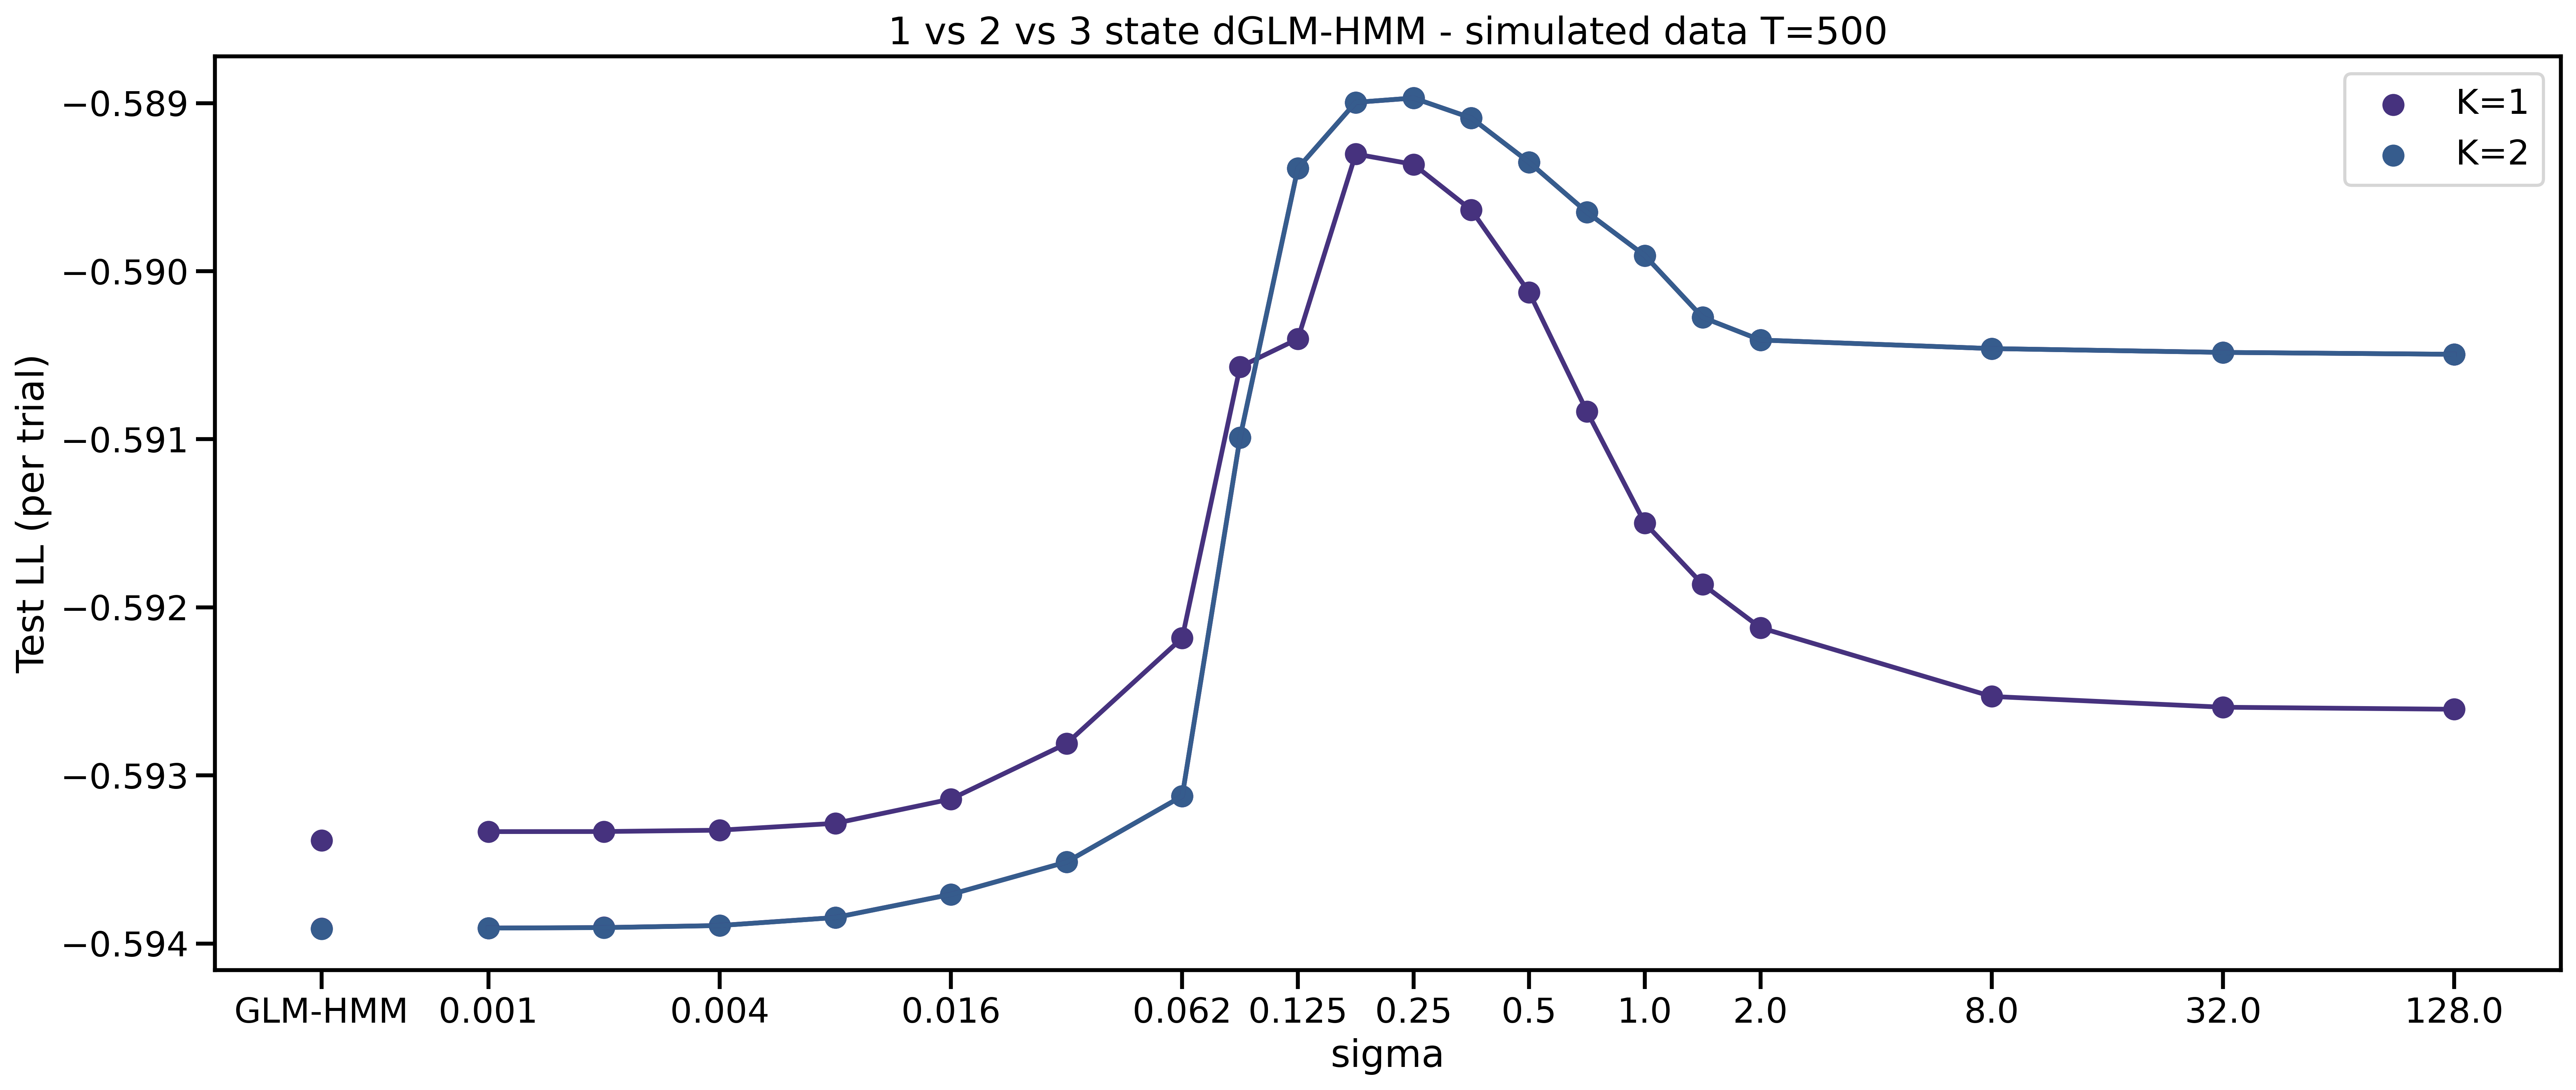

In [30]:
testX = np.load(f'../data/{K}_state_{modelType}_testX.npy')
testY = np.load(f'../data/{K}_state_{modelType}_testY.npy')
allP = np.load(f'../data/P_N={N}_3-fit_{K}_state_{modelType}.npy')
allW = np.load(f'../data/W_N={N}_3-fit_{K}_state_{modelType}.npy')
sess = 10
inits = 1
testLl = np.zeros((inits, len(sigmaList)))
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,3,D,C)
trainSessInd=sessInd
sessInd10000 = []
for sess in range(0,S+1):
    sessInd10000.append(sess*1000)
testSessInd=sessInd10000
# Evaluate on test data
for indSigma in range(0, len(sigmaList)):  
    for s in range(0, sess):
        # evaluate on test data for each session separately
        testPhi = dGLM_HMM.observation_probability(testX, reshapeWeights(allW[0,indSigma], trainSessInd, testSessInd))
        _, _, temp = dGLM_HMM.forward_pass(testY[testSessInd[s]:testSessInd[s+1]],allP[0,indSigma],testPhi[testSessInd[s]:testSessInd[s+1]])
        testLl[init, indSigma] += temp
    
testLl = testLl / testSessInd[-1] # normalizing to the total number of trials in test
np.save(f'../data/testLl_N={N}_3-fit_{K}_state_{modelType}', testLl)

fig, axes = plt.subplots(1, figsize = (20,8), dpi=400)
sigma_testLl_plot(K=1, sigmaList=sigmaList, testLl=testLl, axes=axes, title='2 state dGLM-HMM - simulated data T=500', labels=['K=1'], save_fig=False)
testLl = evaluate_multiple_sigmas_simulated(N,K,D,C, trainSessInd=sessInd, testSessInd=testSessInd, sigmaList = sigmaList, modelType='constant-drift', save=True)
sigma_testLl_plot(K=2, sigmaList=sigmaList, testLl=testLl[0:2,0:len(sigmaList)], axes=axes, title='1 vs 2 vs 3 state dGLM-HMM - simulated data T=500', labels=['','K=2'], save_fig=True)


In [21]:
#Fitting for multiple values of Sigma 
sigmaList = [0] + [2**x for x in list(np.arange(-10,-4,1,dtype=float))] + [2**x for x in list(np.arange(-4,1,0.5,dtype=float))] + [2**x for x in list(np.arange(1,8,2,dtype=float))]
allLl, allP, allW = fit_multiple_sigmas_simulated(N=N,K=K,D=D,C=C, sessInd=sessInd, sigmaList=sigmaList, inits=1, maxiter=300, modelType='constant-drift', save=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


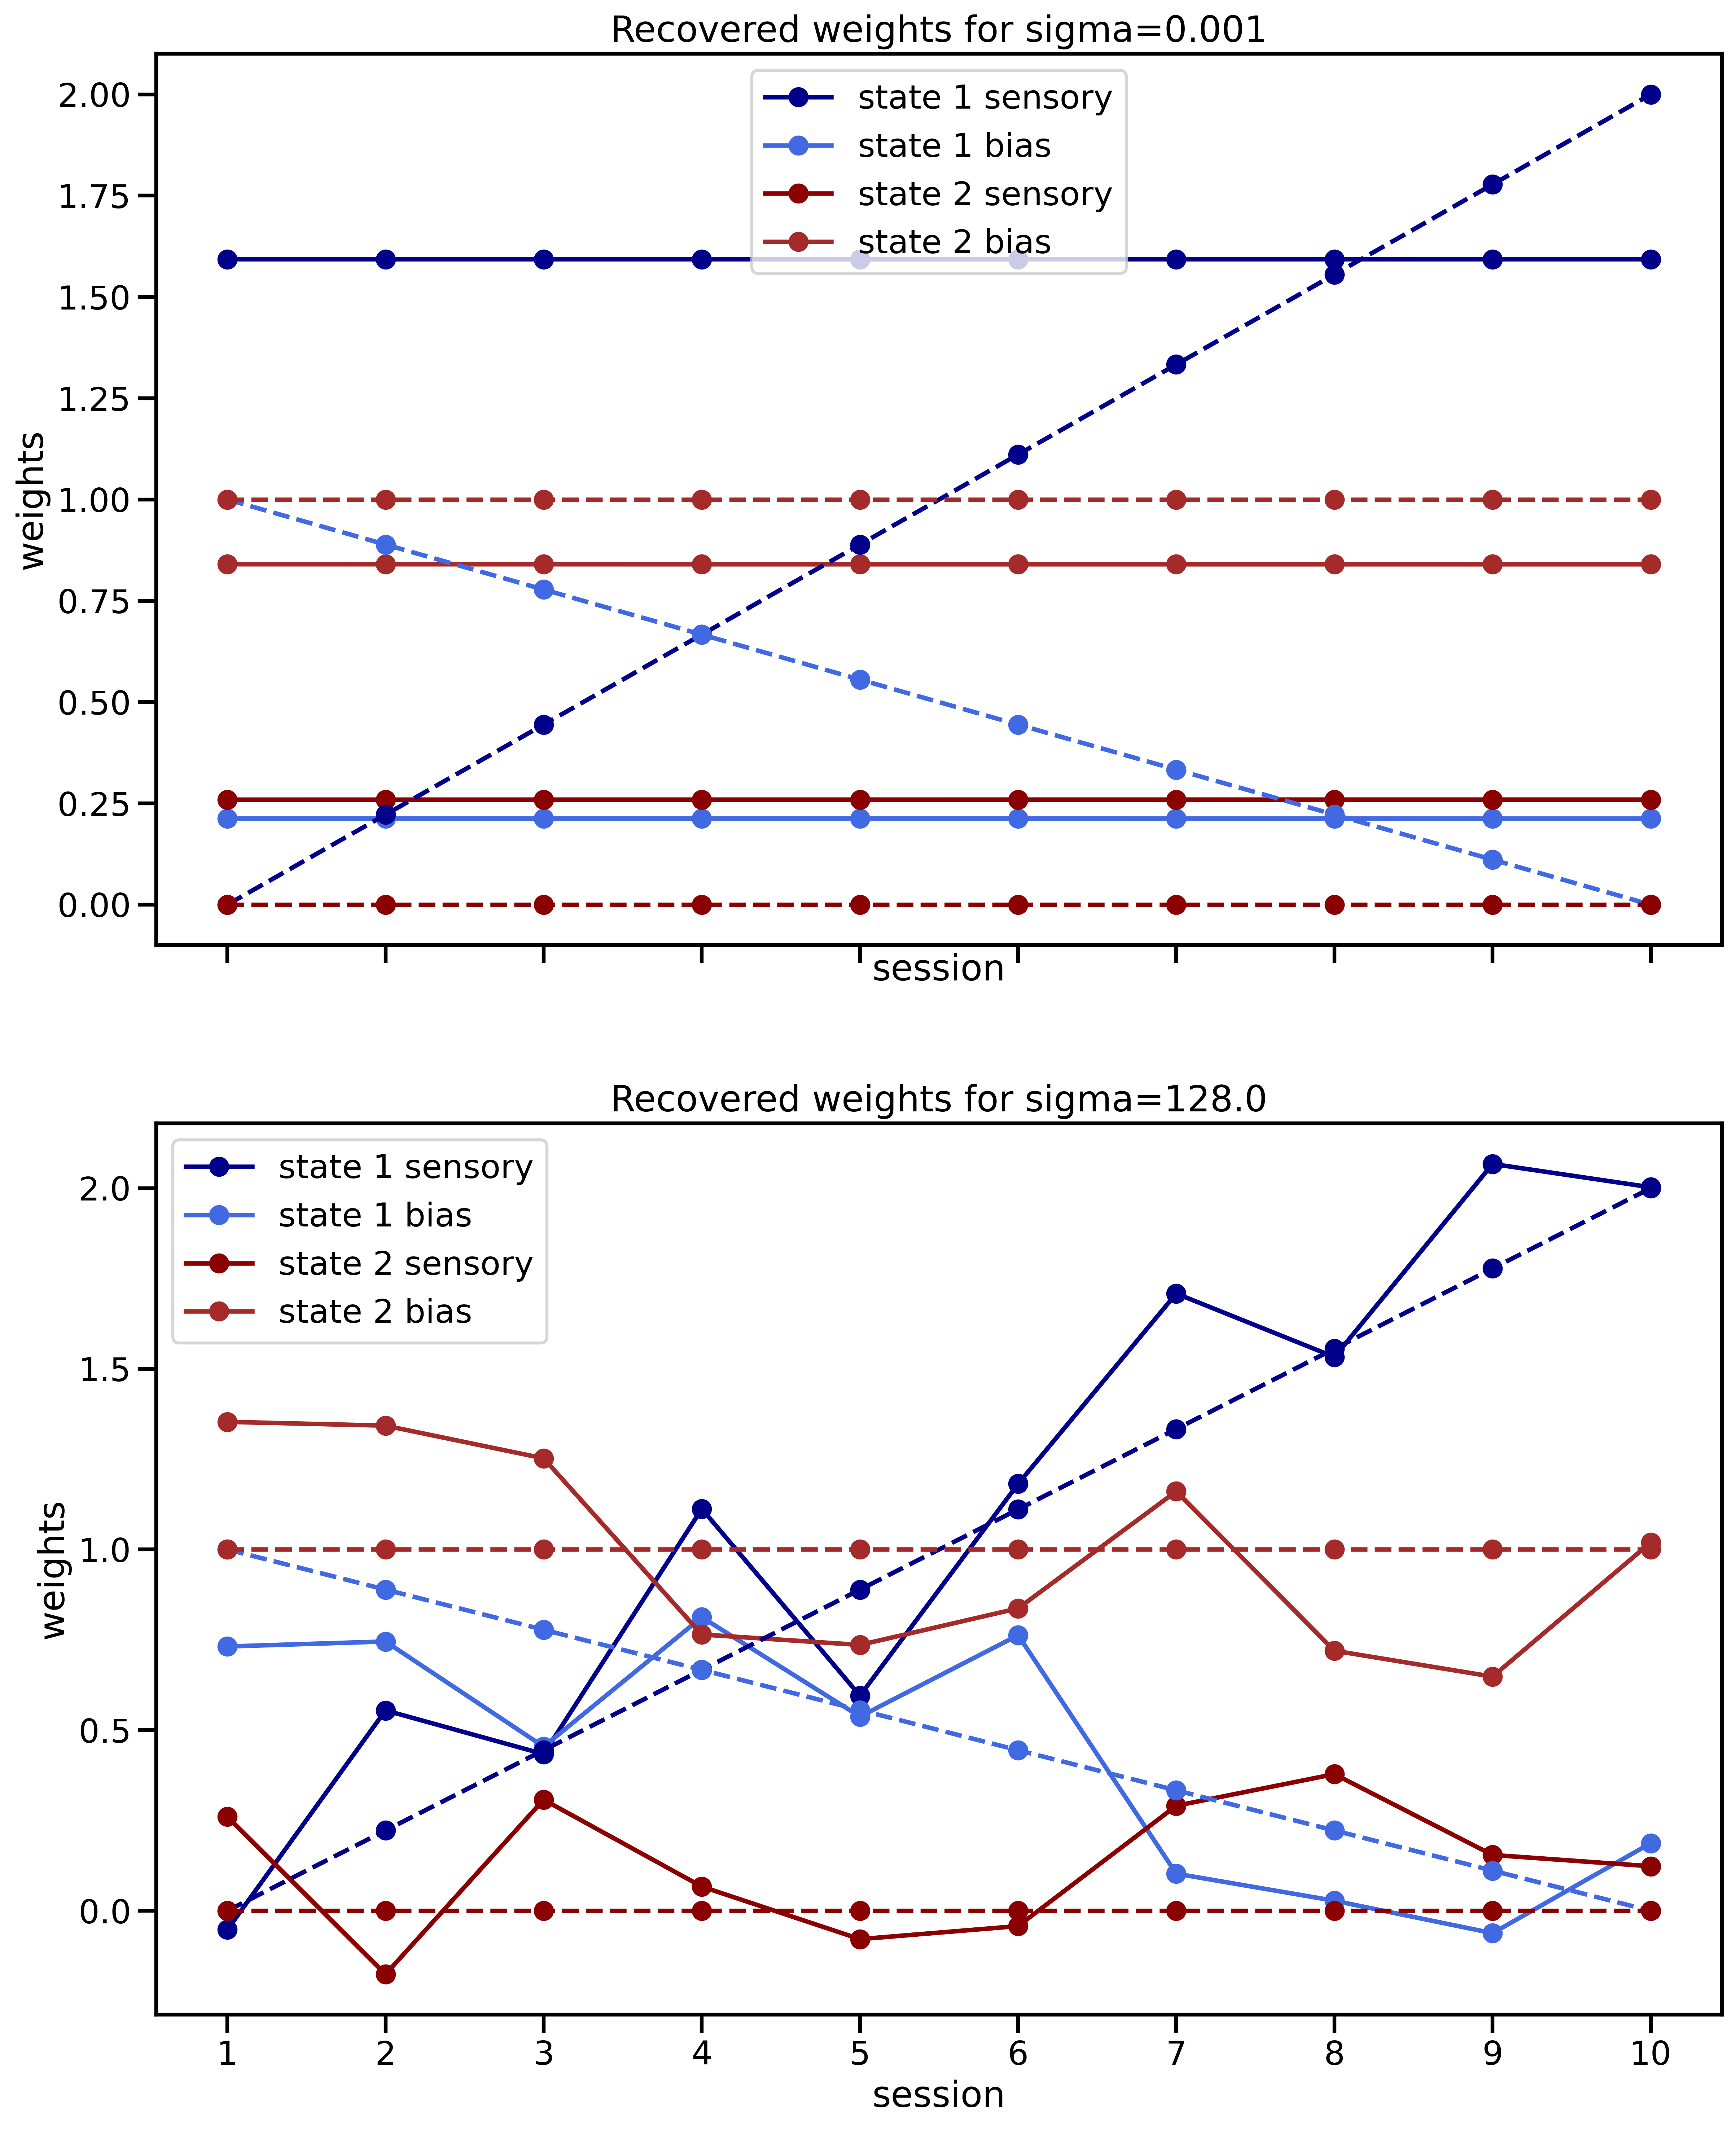

In [5]:
sigmaList = [0] + [2**x for x in list(np.arange(-10,-4,1,dtype=float))] + [2**x for x in list(np.arange(-4,1,0.5,dtype=float))] + [2**x for x in list(np.arange(1,8,2,dtype=float))]
allW = np.load('../data//W_N=5000_2_state_constant-drift.npy')
allP = np.load('../data//P_N=5000_2_state_constant-drift.npy')
init = 0
fig, axes = plt.subplots(2,1, sharex=True ,figsize = (14,18), dpi=400)
plotting_weights(allW[init, 1][:,[1,0],:,:], sessInd, axes=axes[0],  trueW=trueW, title=f'Recovered weights for sigma={np.round(sigmaList[1],3)}', save_fig=False)
plotting_weights(permute_states(allW[init, 20],sessInd), sessInd, axes=axes[1],  trueW=trueW, title=f'Recovered weights for sigma={np.round(sigmaList[20],3)}', save_fig=True)
# 10 or 11 are optimal sigmas
#plotting_weights(permute_states(allW[init, indSigma],sessInd), sessInd, axes=axes,  trueW=trueW, title=f'Recovered weights for sigma={np.round(sigmaList[indSigma],3)}', save_fig=True)

[[0.95536756 0.04463244]
 [0.03341803 0.96658197]]
[[0.95536756 0.03341803]
 [0.04463244 0.96658197]]


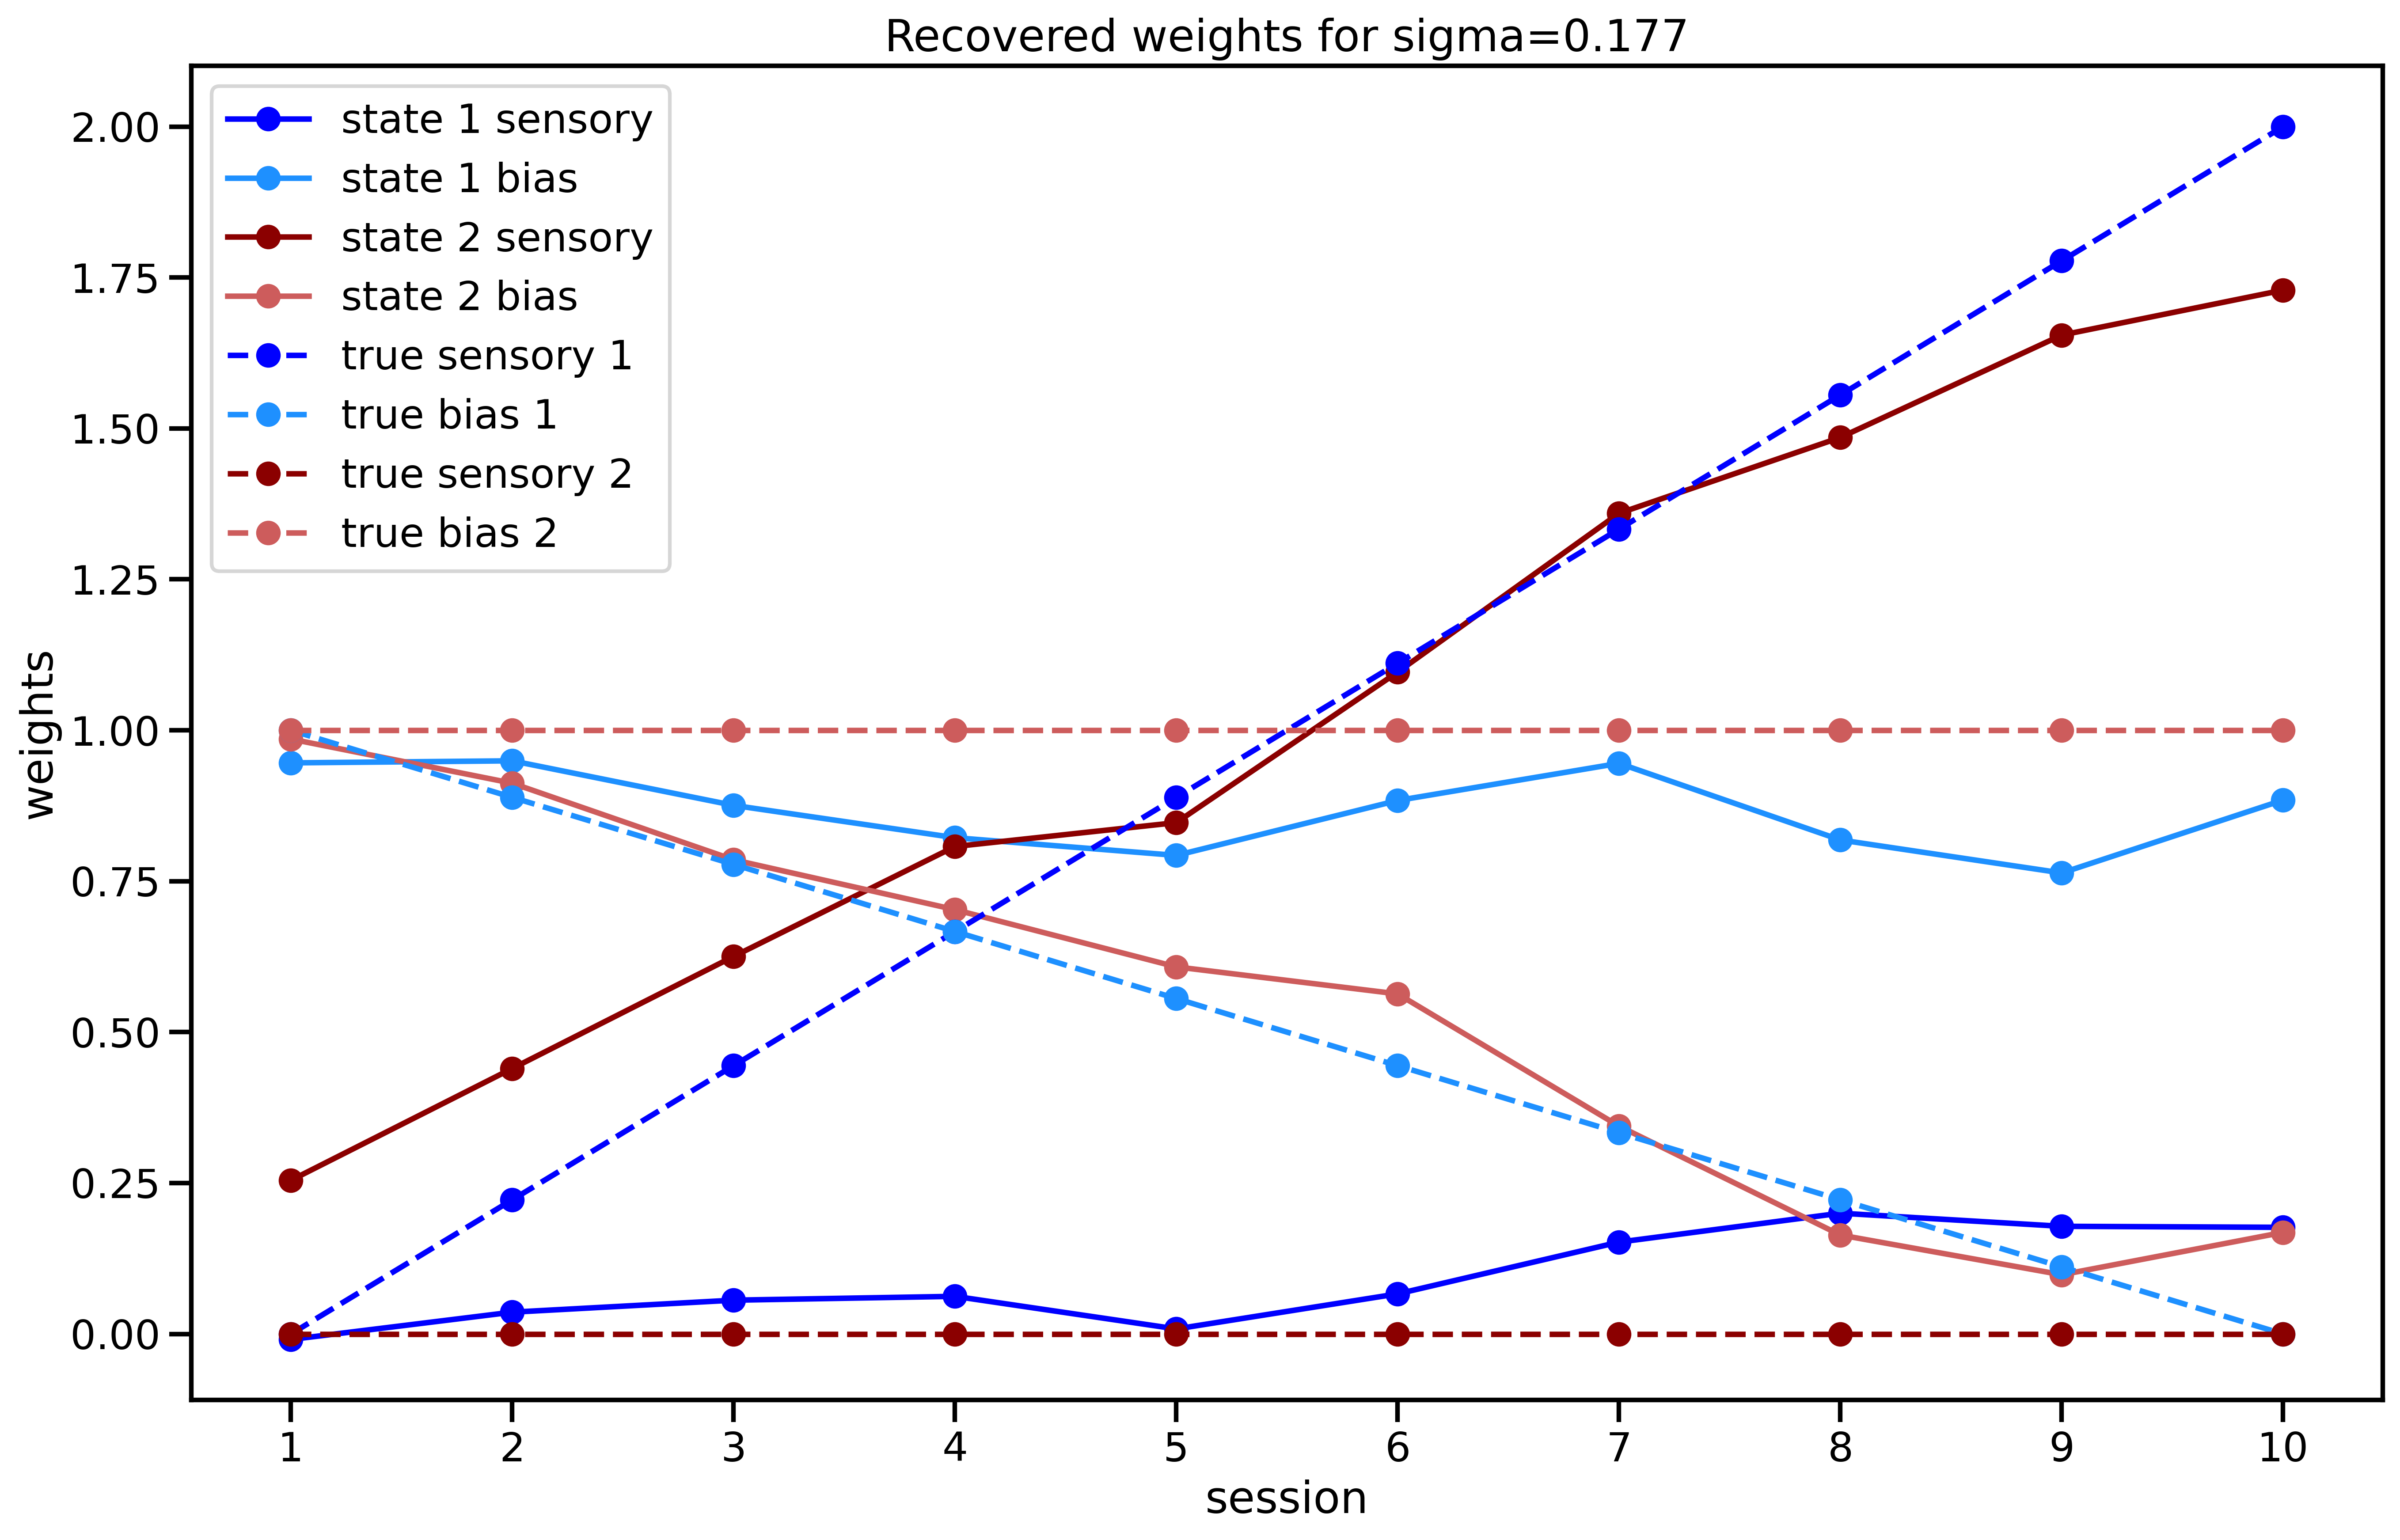

In [45]:
fig, axes = plt.subplots(1, figsize = (16,10), dpi=400)
print(allP[0,10])
print(allP[0,10].T)
plotting_weights(allW[0, 10], sessInd, axes=axes,  trueW=trueW, title=f'Recovered weights for sigma={np.round(sigmaList[10],3)}', save_fig=False)

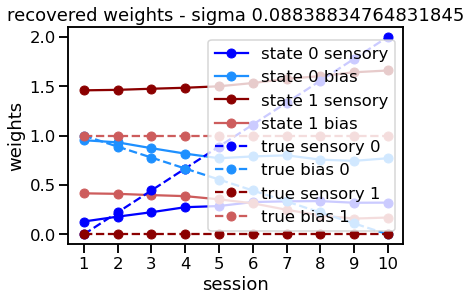

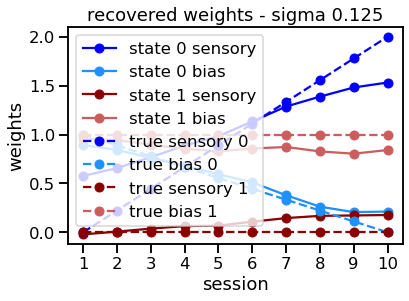

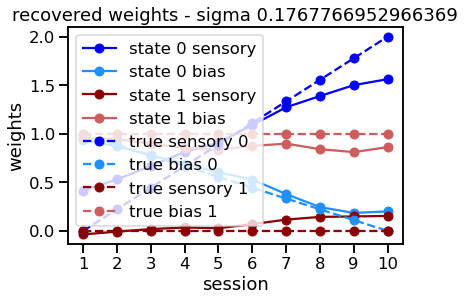

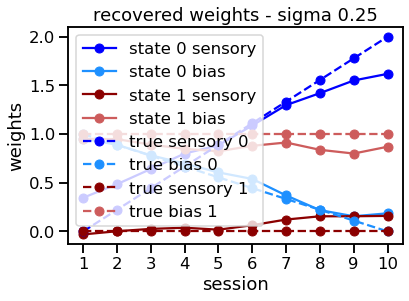

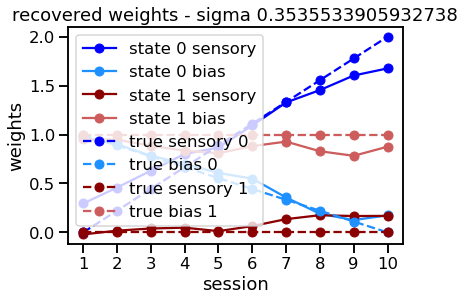

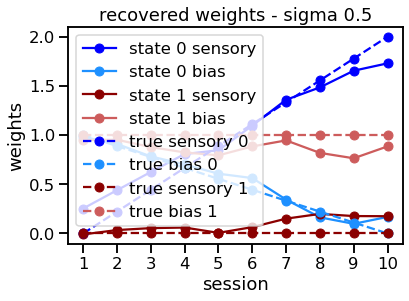

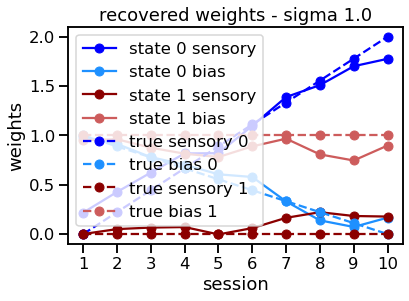

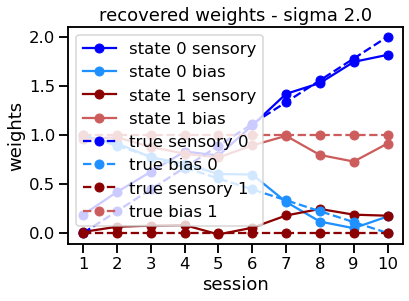

In [15]:
allW = np.load('../data//W_N=5000_2_state_constant-drift.npy')
allP = np.load('../data//P_N=5000_2_state_constant-drift.npy')
for indSigma in range(8,16):
    plotting_weights(permute_states(allW[0, indSigma],sessInd), sessInd, trueW, f'recovered weights - sigma {sigmaList[indSigma]}')

(3, 21)


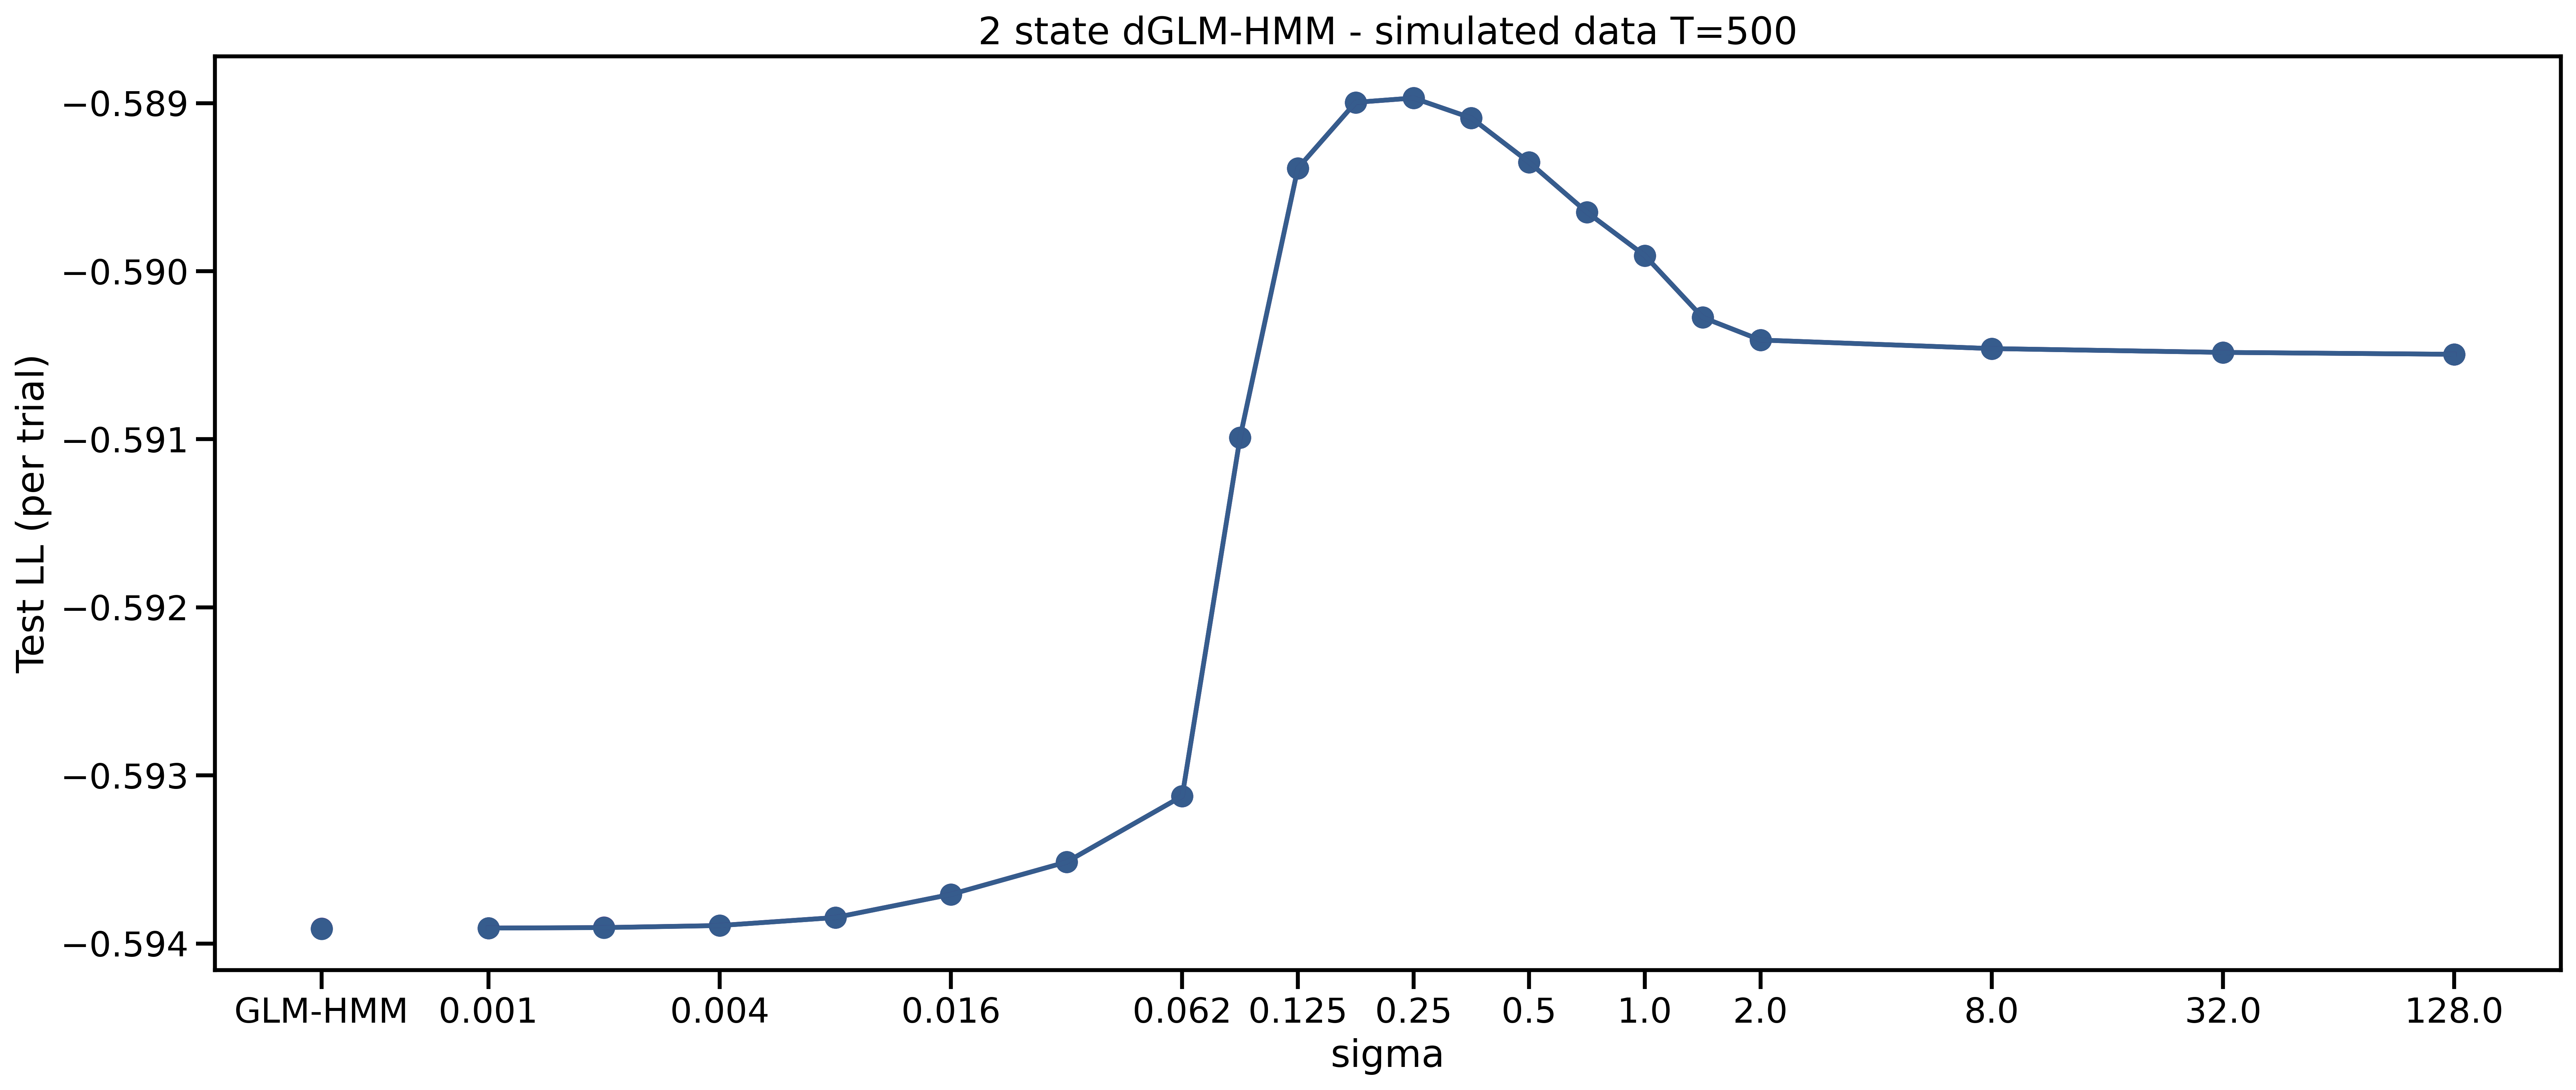

In [24]:
sigmaList = [0] + [2**x for x in list(np.arange(-10,-4,1,dtype=float))] + [2**x for x in list(np.arange(-4,1,0.5,dtype=float))] + [2**x for x in list(np.arange(1,8,2,dtype=float))]
testLl = evaluate_multiple_sigmas_simulated(N,K,D,C, trainSessInd=sessInd, testSessInd=testSessInd, sigmaList = sigmaList, modelType='constant-drift', save=True)
print(testLl.shape)

sigmaList = [0] + [2**x for x in list(np.arange(-10,-4,1,dtype=float))] + [2**x for x in list(np.arange(-4,1,0.5,dtype=float))] + [2**x for x in list(np.arange(1,8,2,dtype=float))]
fig, axes = plt.subplots(1, figsize = (20,8), dpi=400)
sigma_testLl_plot(K=2, sigmaList=sigmaList, testLl=testLl[0:2,0:len(sigmaList)], axes=axes, title='2 state dGLM-HMM - simulated data T=500', labels=None, save_fig=True)


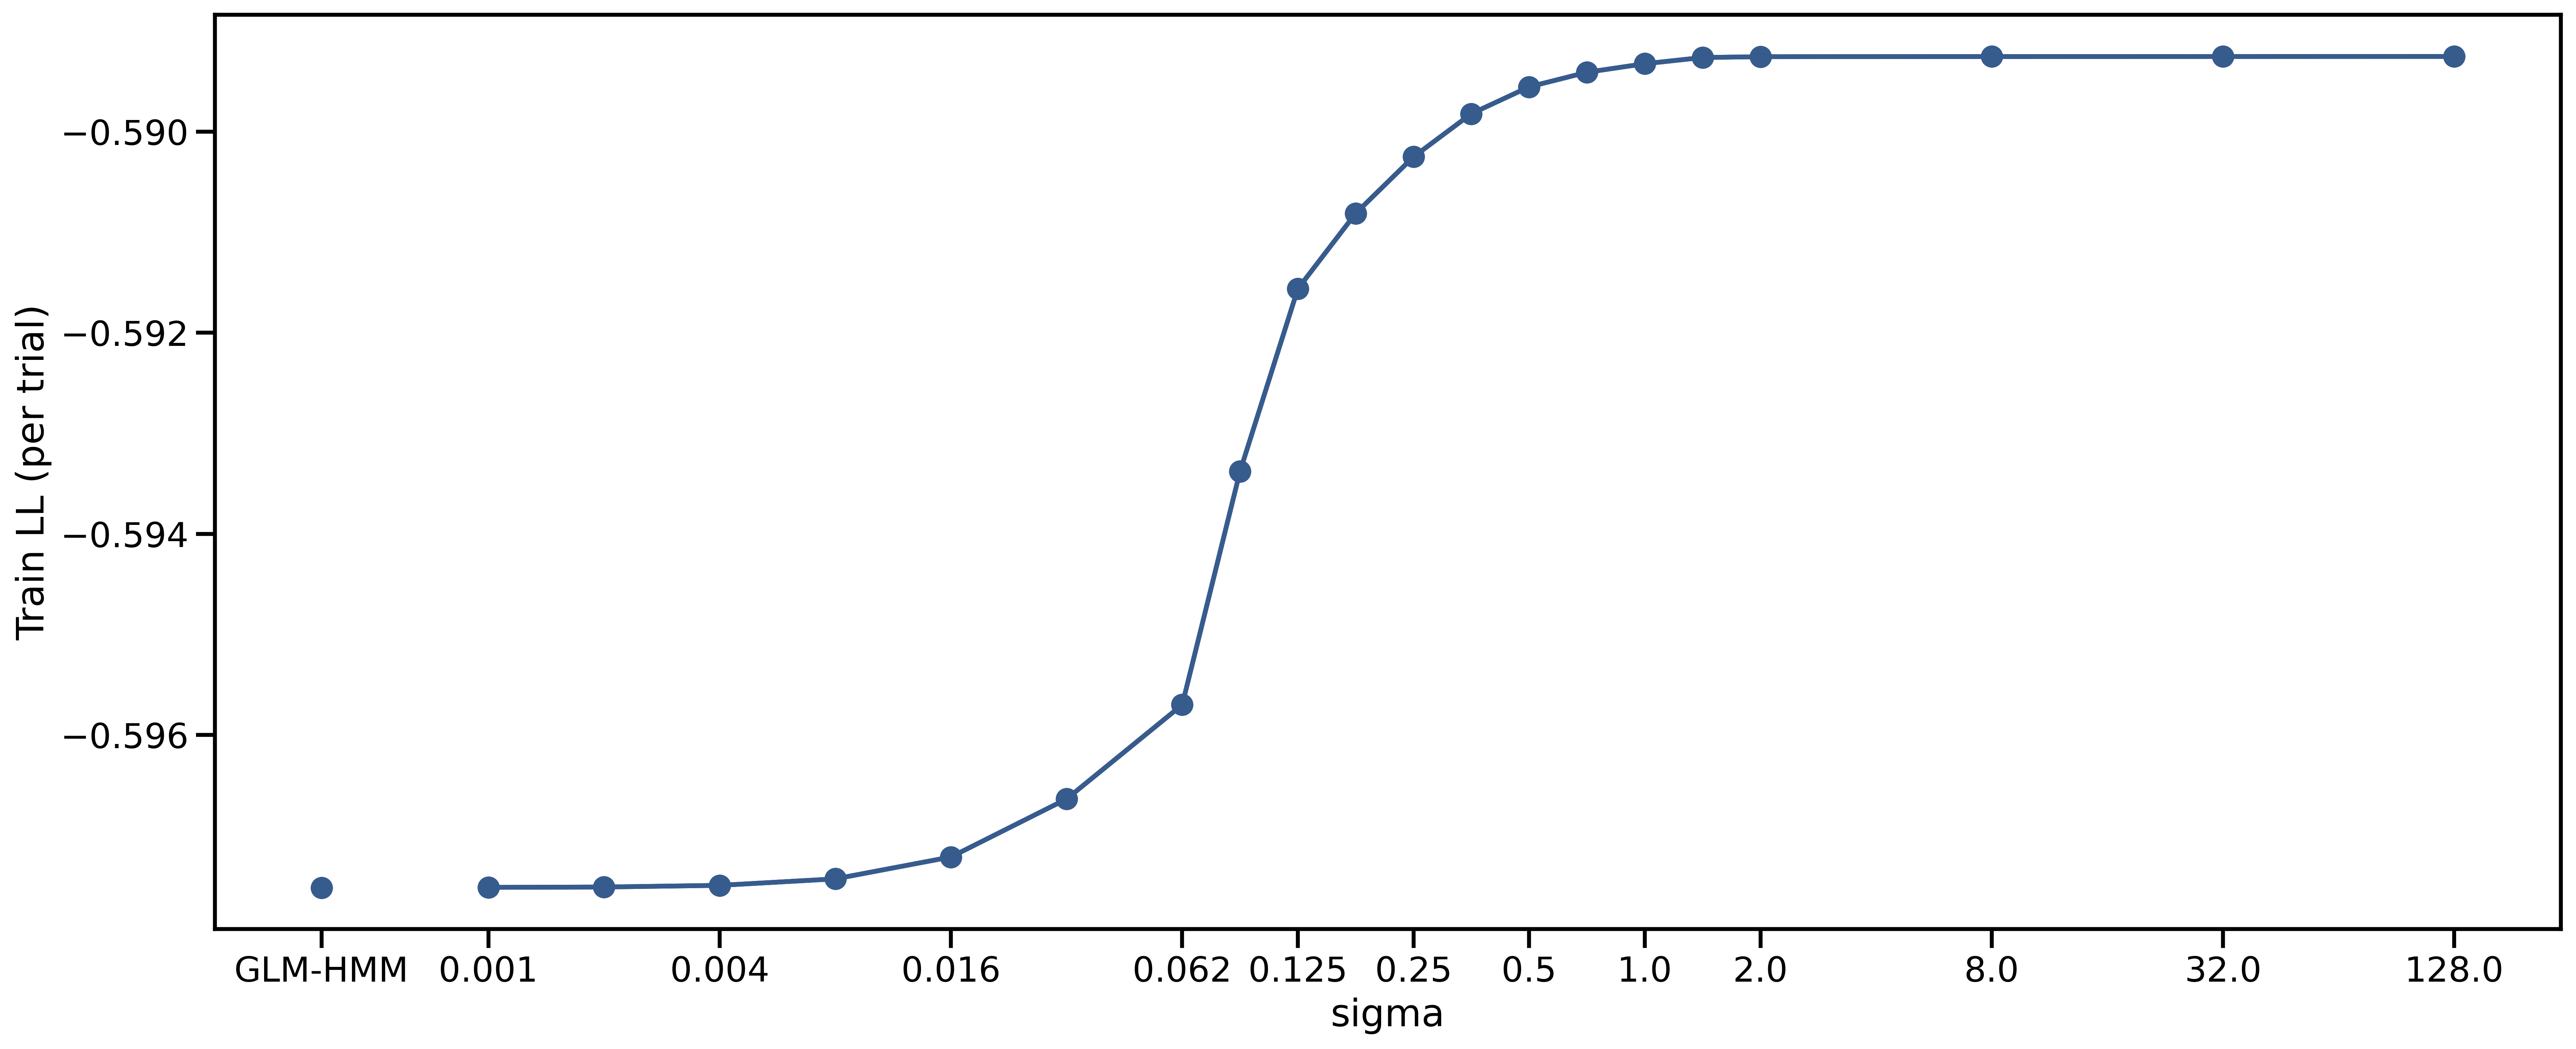

In [6]:
sigmaList = [0] + [2**x for x in list(np.arange(-10,-4,1,dtype=float))] + [2**x for x in list(np.arange(-4,1,0.5,dtype=float))] + [2**x for x in list(np.arange(1,8,2,dtype=float))]
modelType = 'constant-drift'
testX = np.load(f'../data/N={N}_{K}_state_{modelType}_trainX.npy')
testY = np.load(f'../data/N={N}_{K}_state_{modelType}_trainY.npy')
allP = np.load(f'../data/P_N={N}_{K}_state_{modelType}.npy')
allW = np.load(f'../data/W_N={N}_{K}_state_{modelType}.npy')
sess = 10
inits = allW.shape[0]
trainLl = np.zeros((inits, len(sigmaList)))
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)
# Evaluate on test data
for init in range(0,inits):
    for indSigma in range(0, len(sigmaList)):  
        for s in range(0, sess):
            # evaluate on test data for each session separately
            testPhi = dGLM_HMM.observation_probability(testX, allW[init, indSigma])
            _, _, temp = dGLM_HMM.forward_pass(testY[sessInd[s]:sessInd[s+1]],allP[init, indSigma],testPhi[sessInd[s]:sessInd[s+1]])
            trainLl[init, indSigma] += temp
    
trainLl = trainLl / sessInd[-1] # normalizing to the total number of trials in test
# np.save(f'../data/trainLl_N={N}_{K}_state_{modelType}', testLl)

fig, axes = plt.subplots(1, figsize = (20,8), dpi=400)
sigma_testLl_plot(K=2, sigmaList=sigmaList, testLl=trainLl[0:2,0:len(sigmaList)], axes=axes, title='', labels=None, save_fig=True)


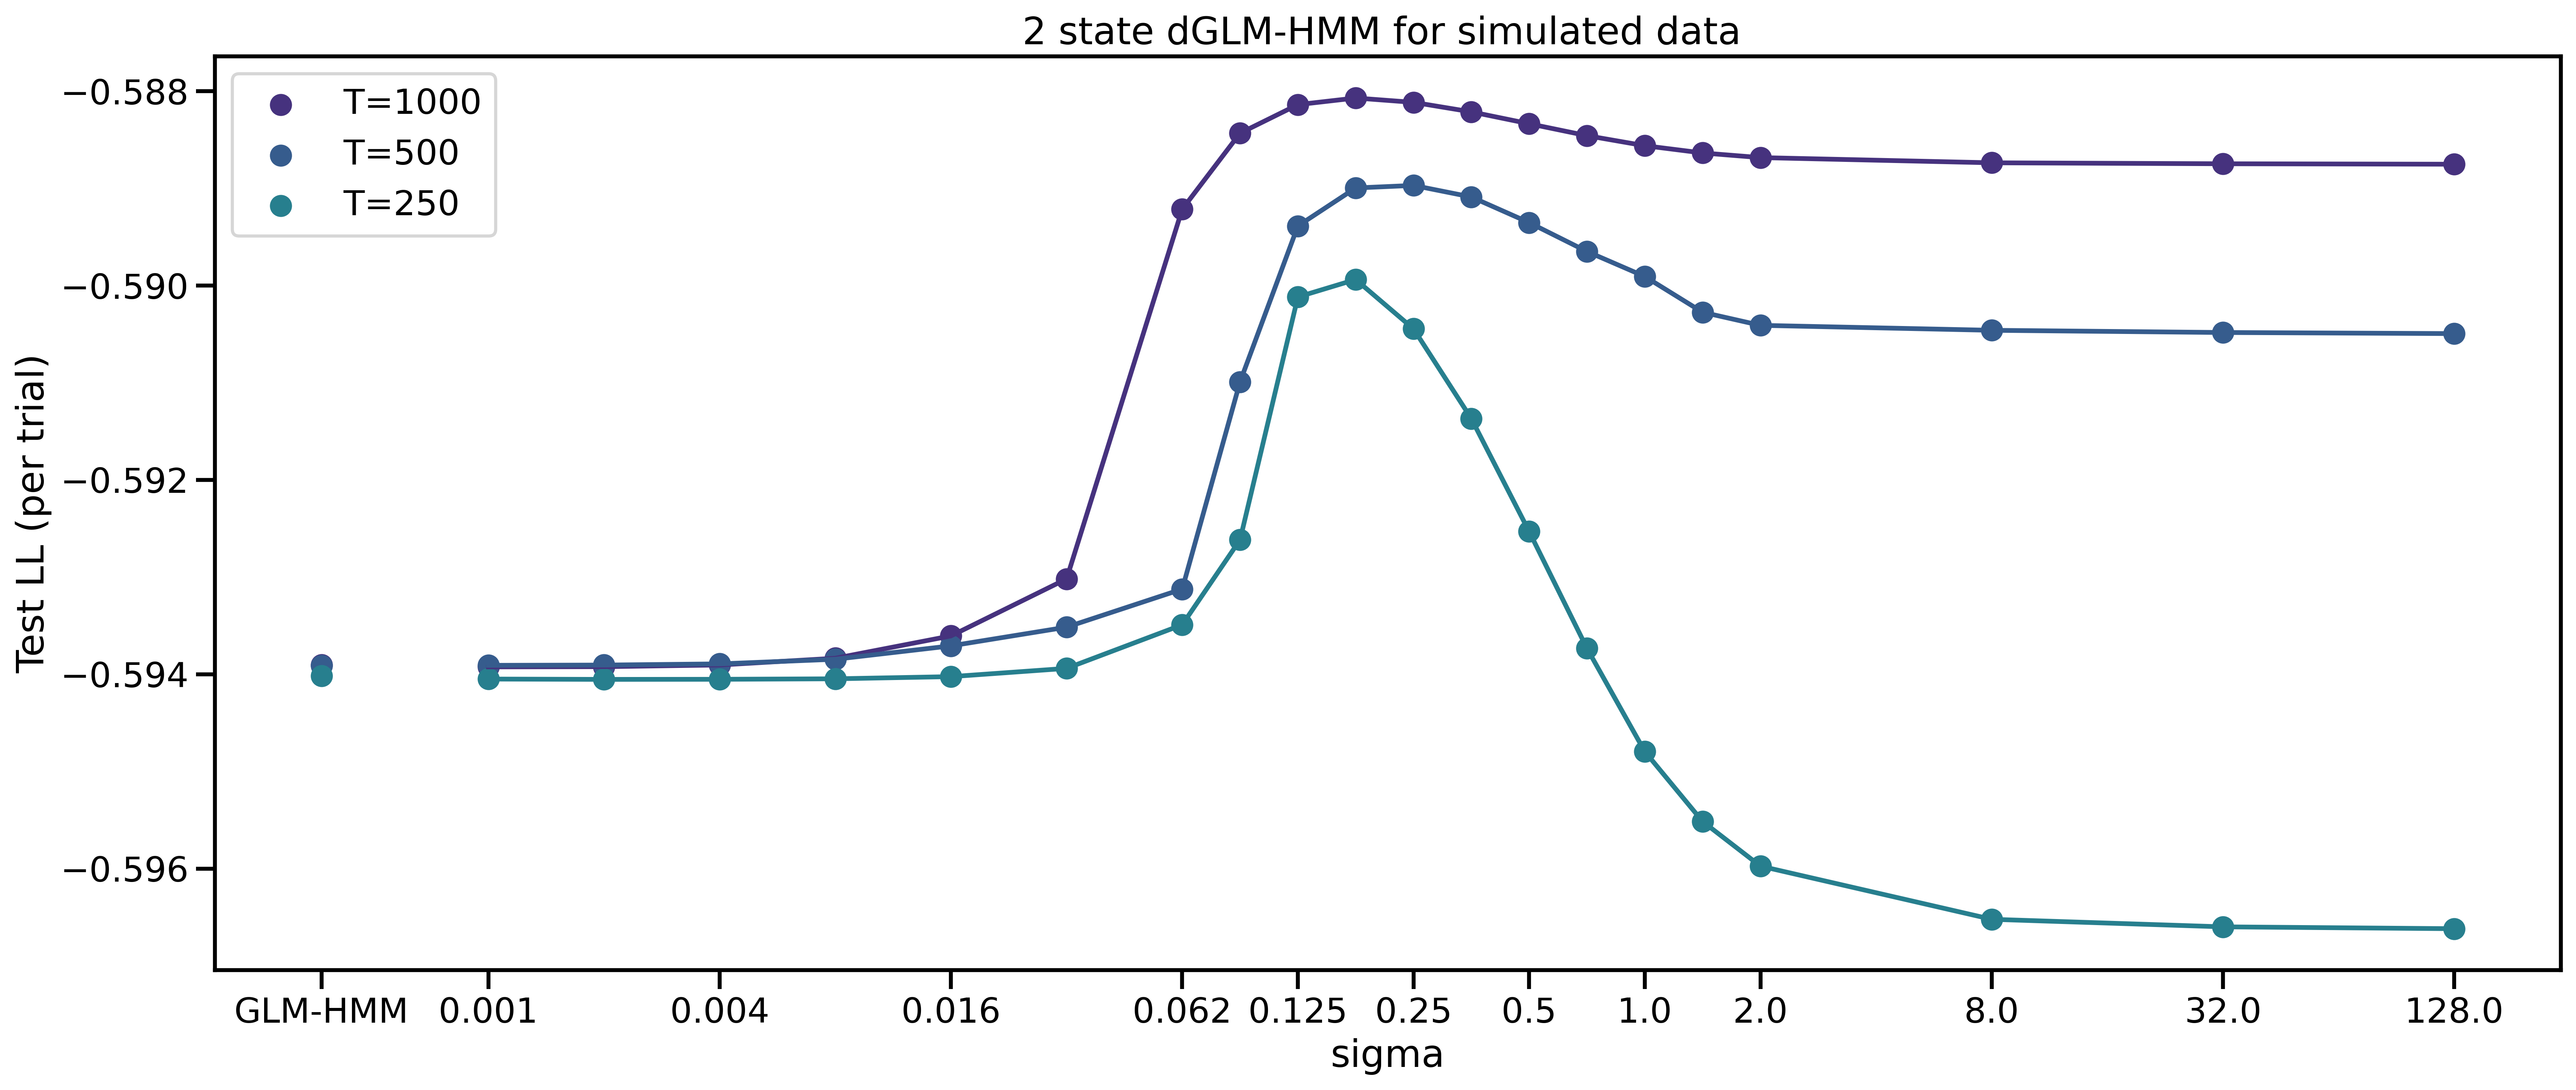

In [6]:
sigmaList = [0] + [2**x for x in list(np.arange(-10,-4,1,dtype=float))] + [2**x for x in list(np.arange(-4,1,0.5,dtype=float))] + [2**x for x in list(np.arange(1,8,2,dtype=float))]
fig, axes = plt.subplots(1, figsize = (20,8), dpi=400)
testLl = np.zeros((3,len(sigmaList)))
sessInd10000 = []
for sess in range(0,S+1):
    sessInd10000.append(sess*1000)
testLl1 = evaluate_multiple_sigmas_simulated(N=10000,K=K,D=D,C=C, trainSessInd=sessInd10000, testSessInd=testSessInd, sigmaList = sigmaList, modelType='constant-drift', save=False)
testLl[0,:] = testLl1[0,:]
#sigma_testLl_plot(K=2, sigmaList=sigmaList, testLl=testLl1[:,0:len(sigmaList)], axes=axes, title='2 state dGLM-HMM - simulated data ', labels=None, save_fig=False)

sessInd5000 = []
for sess in range(0,S+1):
    sessInd5000.append(sess*500)
testLl2 = evaluate_multiple_sigmas_simulated(N=5000,K=K,D=D,C=C, trainSessInd=sessInd5000, testSessInd=testSessInd, sigmaList = sigmaList, modelType='constant-drift', save=False)
testLl[1,:] = testLl2[0,:]
#sigma_testLl_plot(K=2, sigmaList=sigmaList, testLl=testLl2[:,0:len(sigmaList)], axes=axes, title='2 state dGLM-HMM - simulated data ', labels=None, save_fig=False)

sessInd2500 = []
for sess in range(0,S+1):
    sessInd2500.append(sess*250)
testLl3 = evaluate_multiple_sigmas_simulated(N=2500,K=K,D=D,C=C, trainSessInd=sessInd2500, testSessInd=testSessInd, sigmaList = sigmaList, modelType='constant-drift', save=False)
testLl[2,:] = testLl3[0,:]
#sigma_testLl_plot(K=2, sigmaList=sigmaList, testLl=testLl3[:,0:len(sigmaList)], axes=axes, title='2 state dGLM-HMM - simulated data ', labels=None, save_fig=False)

sigma_testLl_plot(K=2, sigmaList=sigmaList, testLl=testLl, axes=axes, title='2 state dGLM-HMM for simulated data ', labels=['T=1000','T=500','T=250'], save_fig=True)

# sessInd1000 = []
# for sess in range(0,S+1):
#     sessInd1000.append(sess*100)
# testLl2 = evaluate_multiple_sigmas_simulated(N=1000,K=K,D=D,C=C, trainSessInd=sessInd1000, testSessInd=testSessInd, sigmaList = sigmaList, modelType='constant-drift', save=False)
# sigma_testLl_plot(K=2, sigmaList=sigmaList, testLl=testLl2[:,0:len(sigmaList)], axes=axes, title='2 state dGLM-HMM - simulated data ', labels=None, save_fig=False)
